In [10]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Load the data
news_data = pd.read_csv('../data/raw_analyst_ratings.csv')
stock_data = pd.read_csv('../data/GOOG_historical_data.csv')

# Parse dates
news_data['date'] = pd.to_datetime(news_data['date'], errors='coerce')
stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce')

# Remove timezone information to make both timezone-naive
news_data['date'] = news_data['date'].dt.tz_localize(None)
stock_data['Date'] = stock_data['Date'].dt.tz_localize(None)


analyzer = SentimentIntensityAnalyzer()
news_data['sentiment'] = news_data['headline'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Aggregate sentiment by date
daily_sentiment = news_data.groupby(news_data['date'])['sentiment'].mean().reset_index()
# Optionally, fill or drop missing values if necessary
daily_sentiment = daily_sentiment.dropna()
stock_data = stock_data.dropna()

# Calculate daily stock returns
stock_data['daily_return'] = stock_data['Close'].pct_change()

# Merge sentiment data with stock data
# Perform the merge again after ensuring both DataFrames have valid dates
merged_data = pd.merge(daily_sentiment, stock_data, left_on='date', right_on='Date')

# Drop rows with missing data in the merged DataFrame
merged_data = merged_data.dropna(subset=['sentiment', 'daily_return'])

# Recheck if there are any valid rows
print("Merged Data Info:")
print(merged_data.info())
# Strip time information and ensure both columns are of the same type
daily_sentiment['date'] = daily_sentiment['date'].dt.date
stock_data['Date'] = stock_data['Date'].dt.date

print("Sentiment Date Range:", daily_sentiment['date'].min(), "to", daily_sentiment['date'].max())
print("Stock Date Range:", stock_data['Date'].min(), "to", stock_data['Date'].max())


Merged Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          0 non-null      datetime64[ns]
 1   sentiment     0 non-null      float64       
 2   Date          0 non-null      datetime64[ns]
 3   Open          0 non-null      float64       
 4   High          0 non-null      float64       
 5   Low           0 non-null      float64       
 6   Close         0 non-null      float64       
 7   Adj Close     0 non-null      float64       
 8   Volume        0 non-null      int64         
 9   Dividends     0 non-null      float64       
 10  Stock Splits  0 non-null      float64       
 11  daily_return  0 non-null      float64       
dtypes: datetime64[ns](2), float64(9), int64(1)
memory usage: 132.0 bytes
None
Sentiment Date Range: 2011-04-27 to 2020-06-11
Stock Date Range: 2004-08-19 to 2024-07-30


In [11]:
print("Daily aggregate of  Sentiment Data:")
print(daily_sentiment.head())
print(daily_sentiment.info())

print("Stock Data:")
print(stock_data.head())
print(stock_data.info())
print("Sentiment Date Type:", daily_sentiment['date'].dtype)
print("Stock Date Type:", stock_data['Date'].dtype)

print("Daily Sentiment Missing Values:")
print(daily_sentiment.isna().sum())

print("Stock Data Missing Values:")
print(stock_data.isna().sum())

# Optionally, fill or drop missing values if necessary
daily_sentiment = daily_sentiment.dropna()
stock_data = stock_data.dropna()
# Perform the merge again after ensuring both DataFrames have valid dates
merged_data = pd.merge(daily_sentiment, stock_data, left_on='date', right_on='Date')

# Drop rows with missing data in the merged DataFrame
merged_data = merged_data.dropna(subset=['sentiment', 'daily_return'])

# Recheck if there are any valid rows
print("Merged Data Info:")
print(merged_data.info())

# Print a few rows from each DataFrame for inspection
print("Daily Sentiment Sample:")
print(daily_sentiment.head())

print("Stock Data Sample:")
print(stock_data.head())

# Calculate correlation between sentiment and daily return
correlation = merged_data[['sentiment', 'daily_return']].corr().iloc[0, 1]
print(f"Correlation between sentiment and daily return: {correlation:.2f}")


Daily aggregate of  Sentiment Data:
         date  sentiment
0  2011-04-27     0.0000
1  2011-04-28     0.0000
2  2011-04-28     0.2500
3  2011-04-29     0.0000
4  2011-04-29     0.7351
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36011 entries, 0 to 36010
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       36011 non-null  object 
 1   sentiment  36011 non-null  float64
dtypes: float64(1), object(1)
memory usage: 562.8+ KB
None
Stock Data:
         Date      Open      High       Low     Close  Adj Close     Volume  \
0  2004-08-19  2.490664  2.591785  2.390042  2.499133   2.496292  897427216   
1  2004-08-20  2.515820  2.716817  2.503118  2.697639   2.694573  458857488   
2  2004-08-23  2.758411  2.826406  2.716070  2.724787   2.721690  366857939   
3  2004-08-24  2.770615  2.779581  2.579581  2.611960   2.608991  306396159   
4  2004-08-25  2.614201  2.689918  2.587302  2.640104   2.637103  184645512   



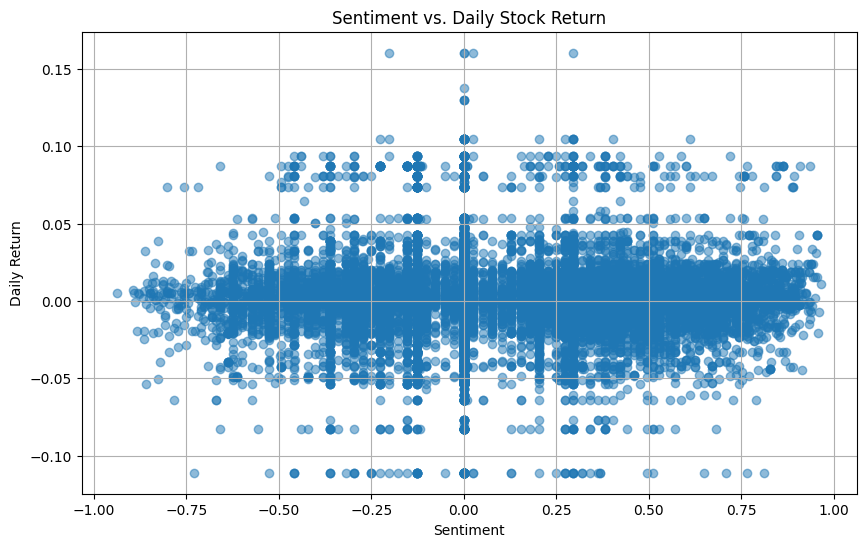

In [15]:
import matplotlib.pyplot as plt

# Scatter plot of sentiment vs daily return
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['sentiment'], merged_data['daily_return'], alpha=0.5)
plt.title('Sentiment vs. Daily Stock Return')
plt.xlabel('Sentiment')
plt.ylabel('Daily Return')
plt.grid(True)
plt.show()


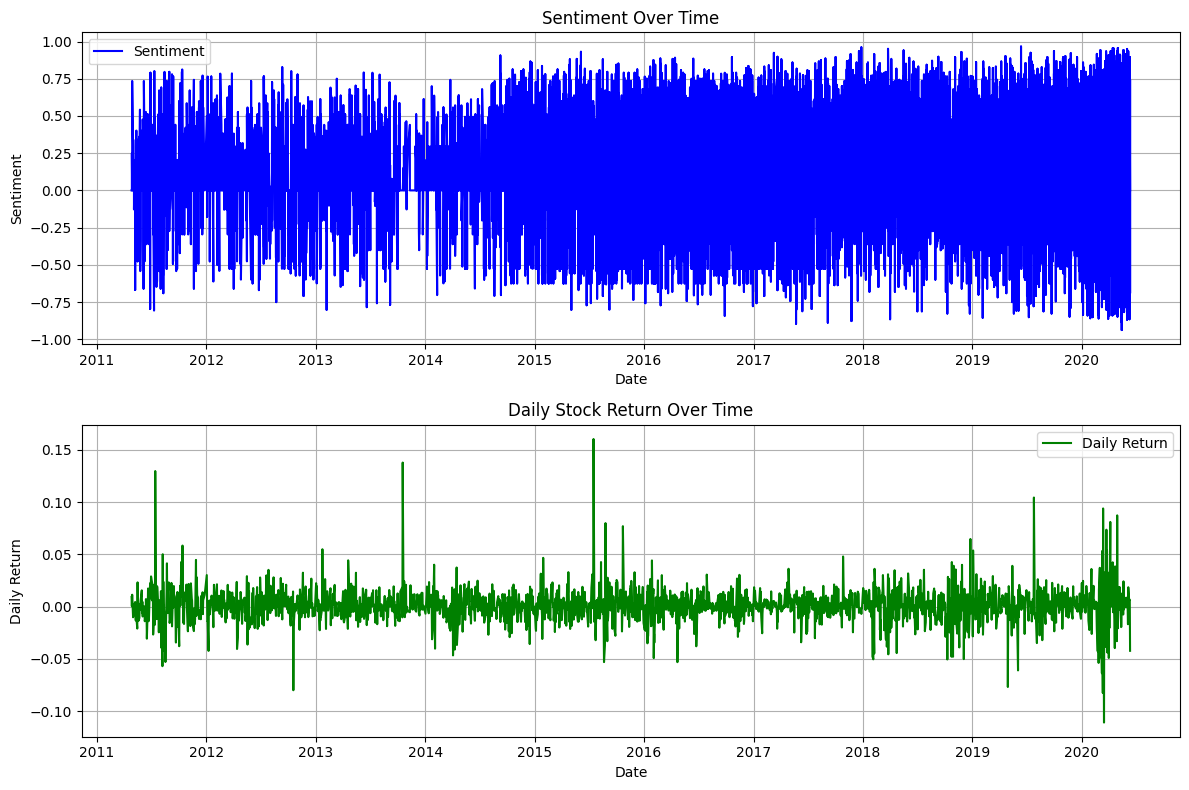

In [16]:
plt.figure(figsize=(12, 8))

# Plot sentiment
plt.subplot(2, 1, 1)
plt.plot(merged_data['date'], merged_data['sentiment'], color='blue', label='Sentiment')
plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.legend()
plt.grid(True)

# Plot daily return
plt.subplot(2, 1, 2)
plt.plot(merged_data['date'], merged_data['daily_return'], color='green', label='Daily Return')
plt.title('Daily Stock Return Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


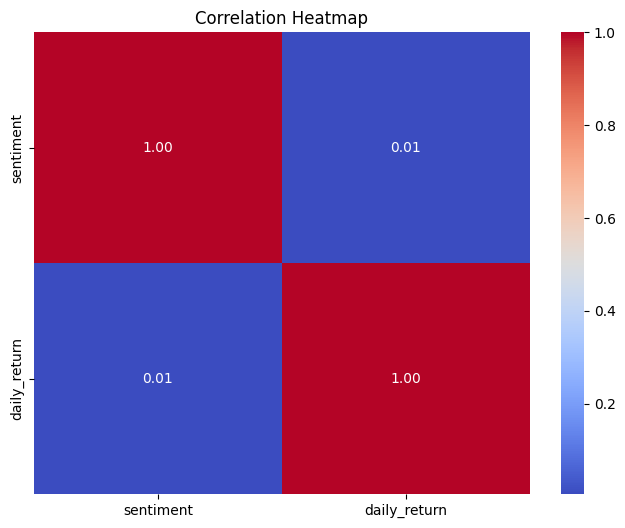

In [17]:
import seaborn as sns

# Create a heatmap for correlation
plt.figure(figsize=(8, 6))
correlation_matrix = merged_data[['sentiment', 'daily_return']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

Correlation between sentiment and daily return for GOOG: 0.01
Correlation between sentiment and daily return for META: -0.00
Correlation between sentiment and daily return for MSFT: 0.00
Correlation between sentiment and daily return for NVDA: 0.00
Correlation between sentiment and daily return for AAPL: 0.01
Correlation between sentiment and daily return for AMZN: 0.00

Summary of Correlations:
  Stock  Correlation
0  GOOG     0.005074
1  META    -0.000553
2  MSFT     0.003382
3  NVDA     0.002308
4  AAPL     0.007502
5  AMZN     0.004048


C:\Users\Akram 1\AppData\Local\Temp\ipykernel_10312\259711830.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Stock', y='Correlation', data=summary_df, palette='viridis')


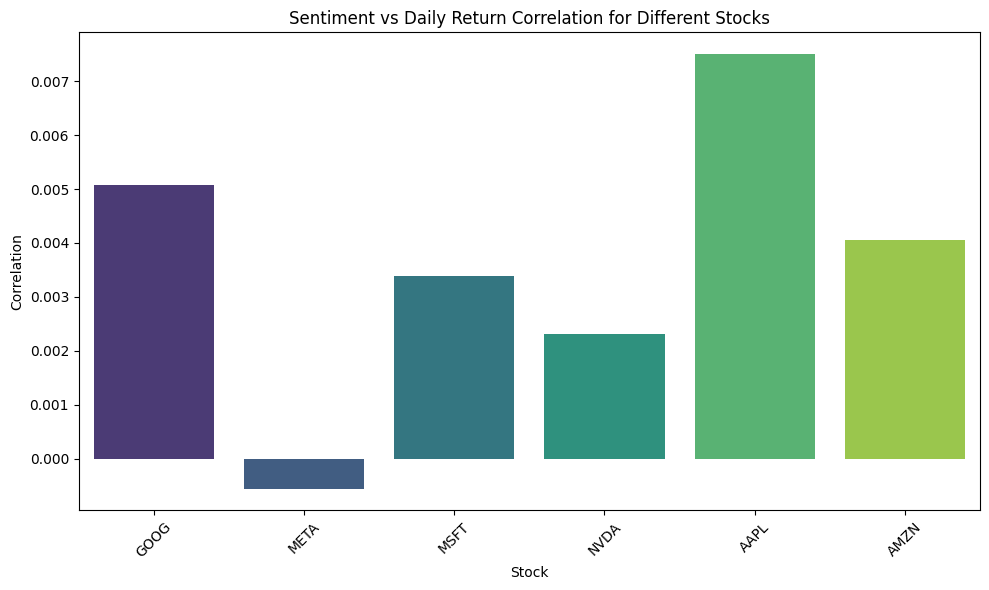

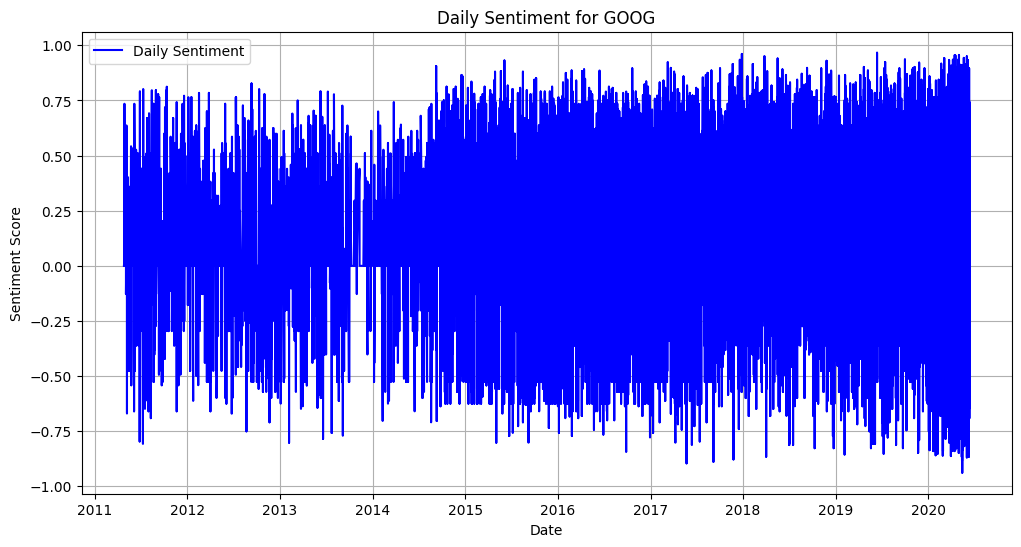

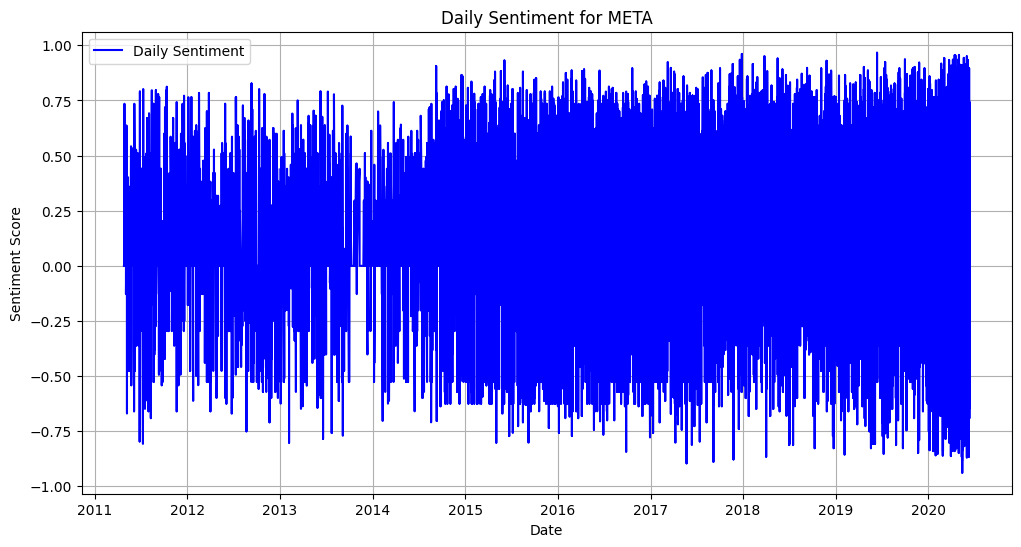

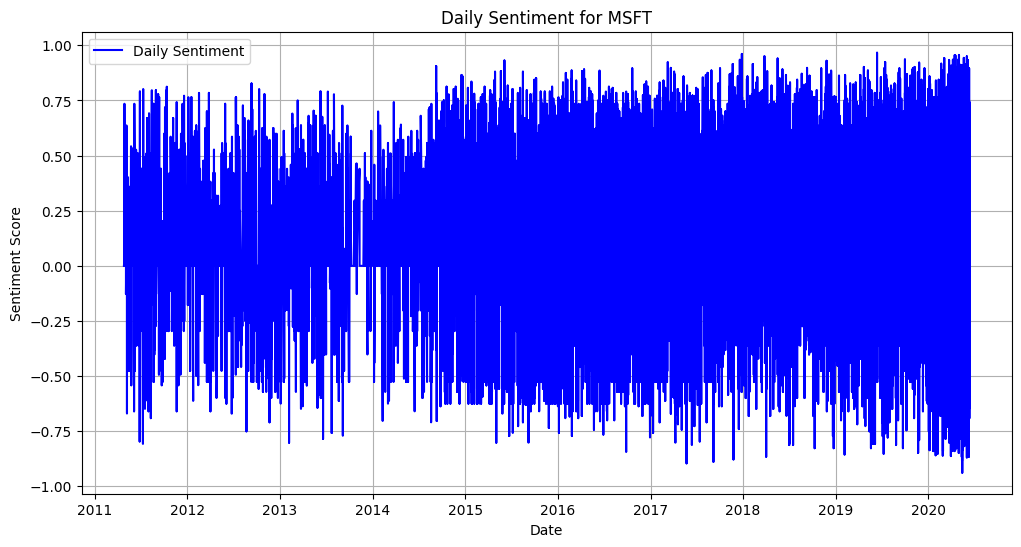

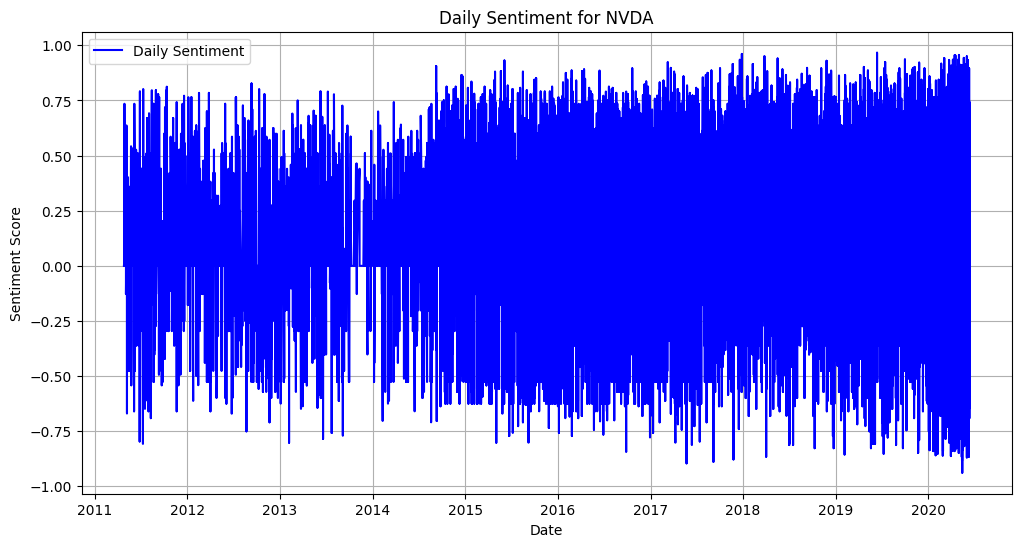

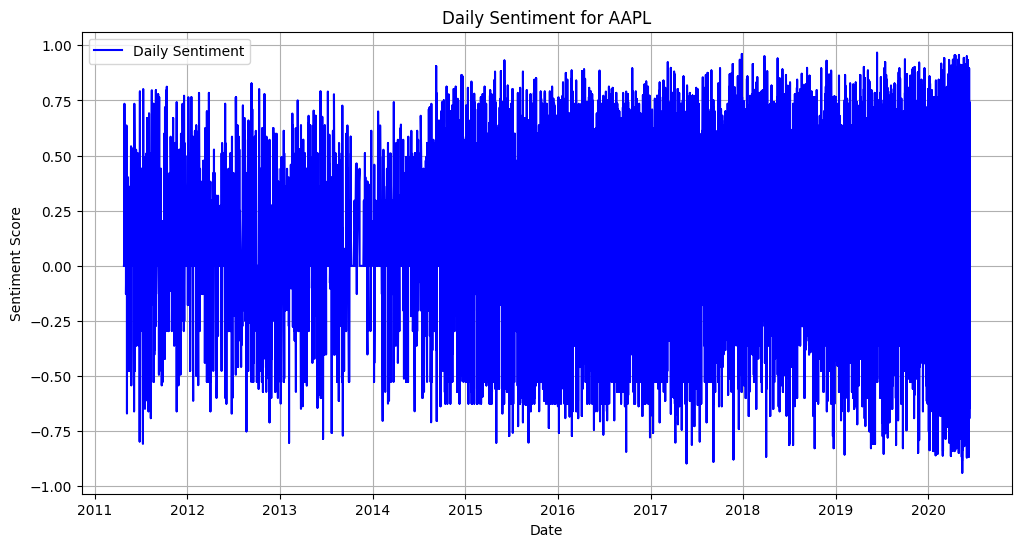

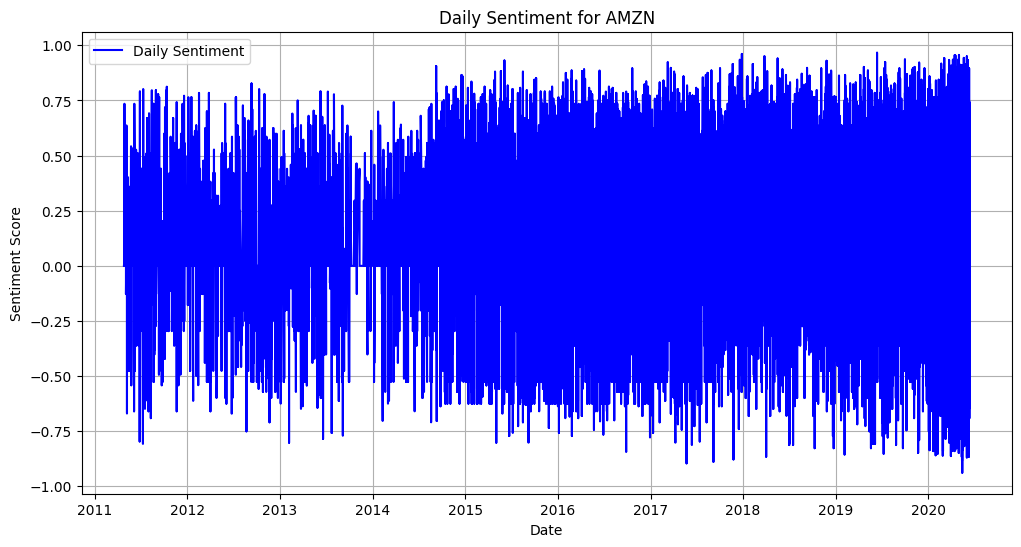

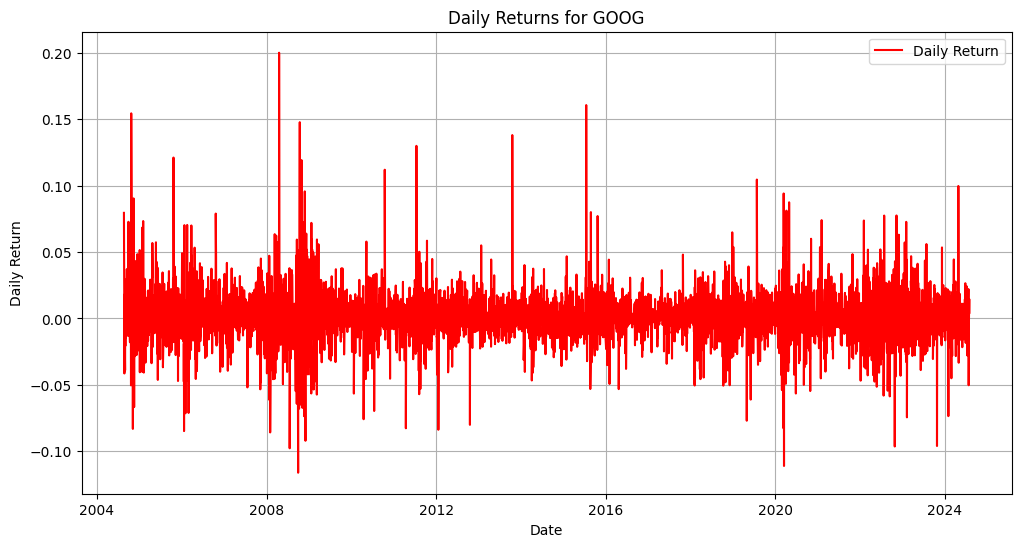

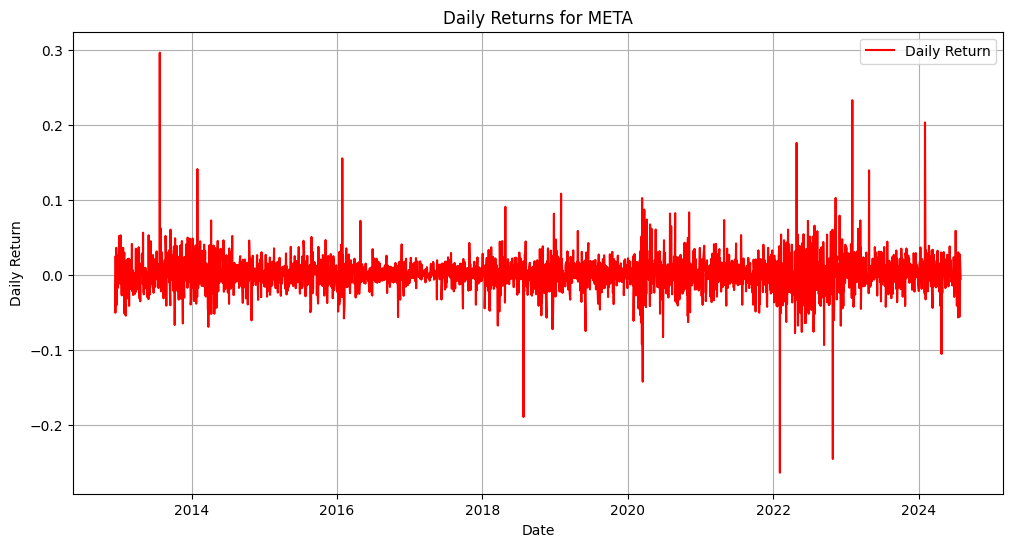

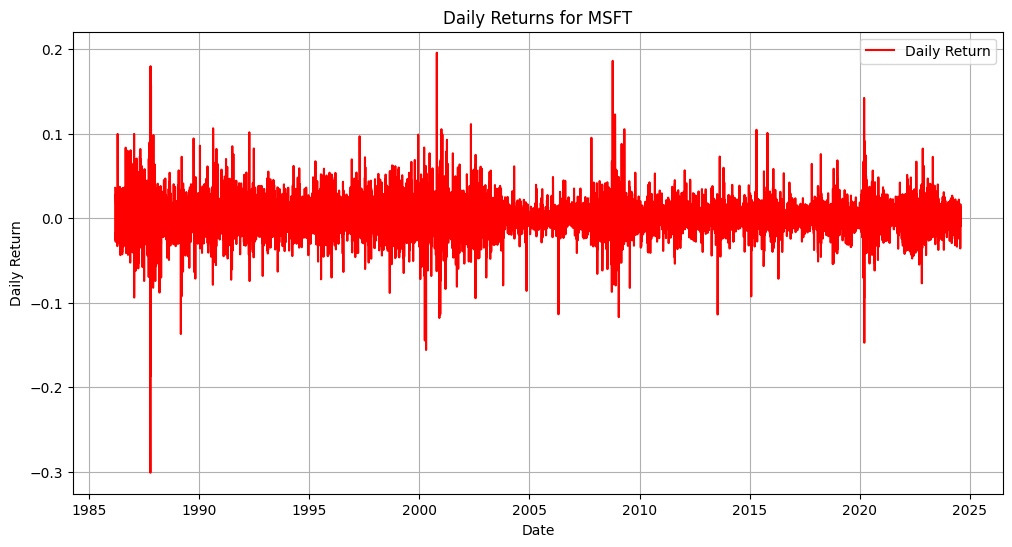

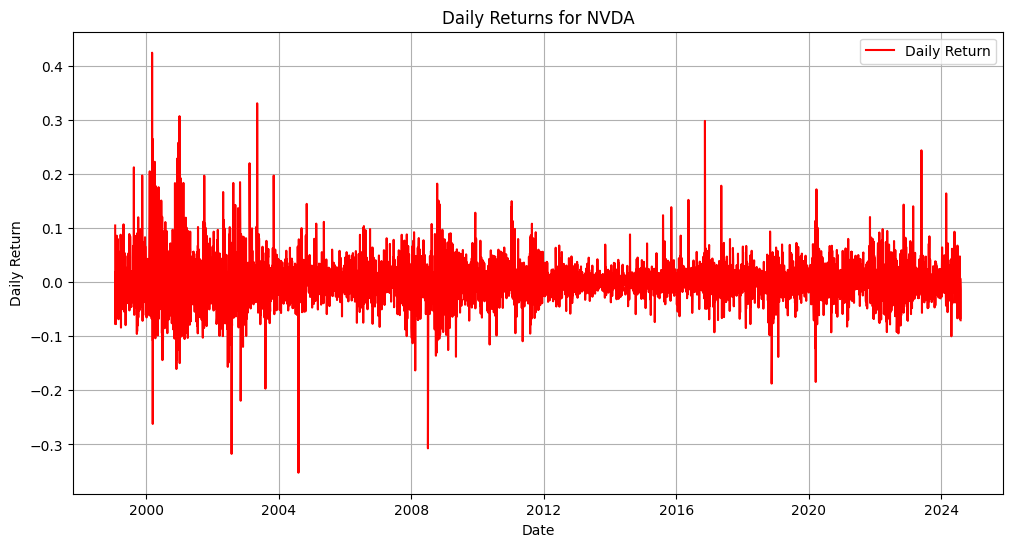

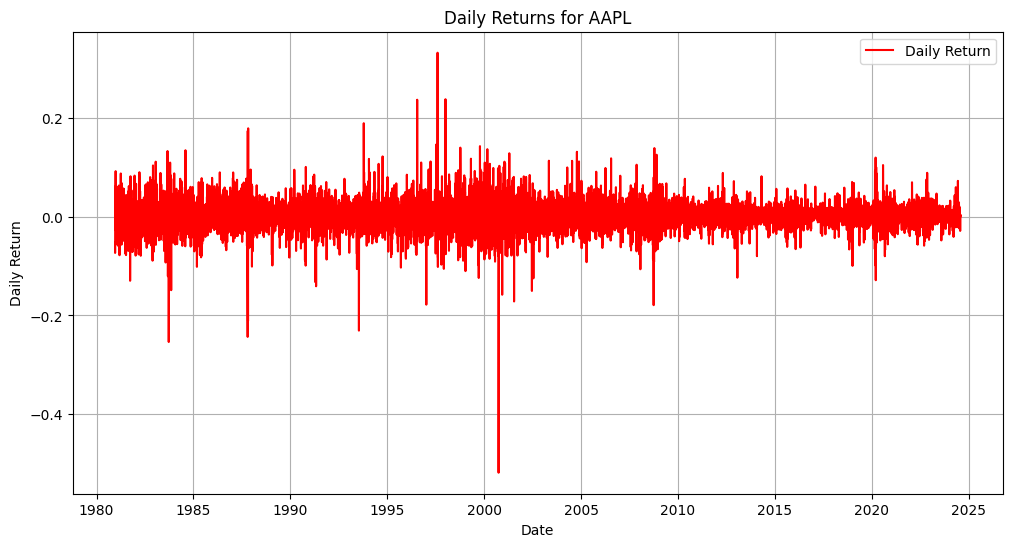

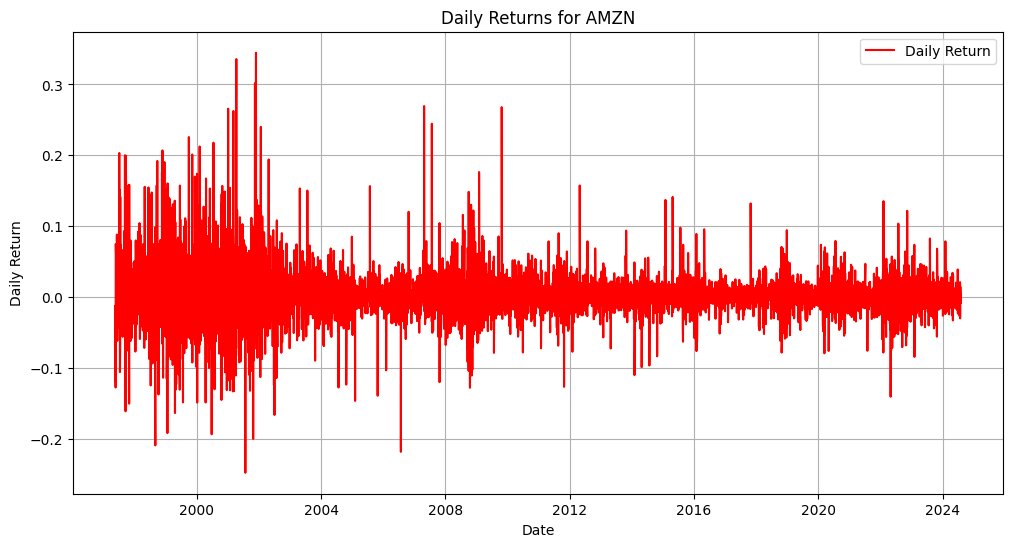

c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


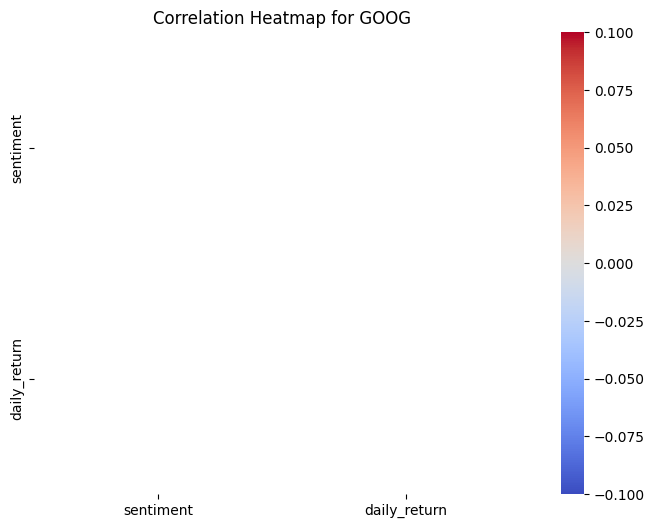

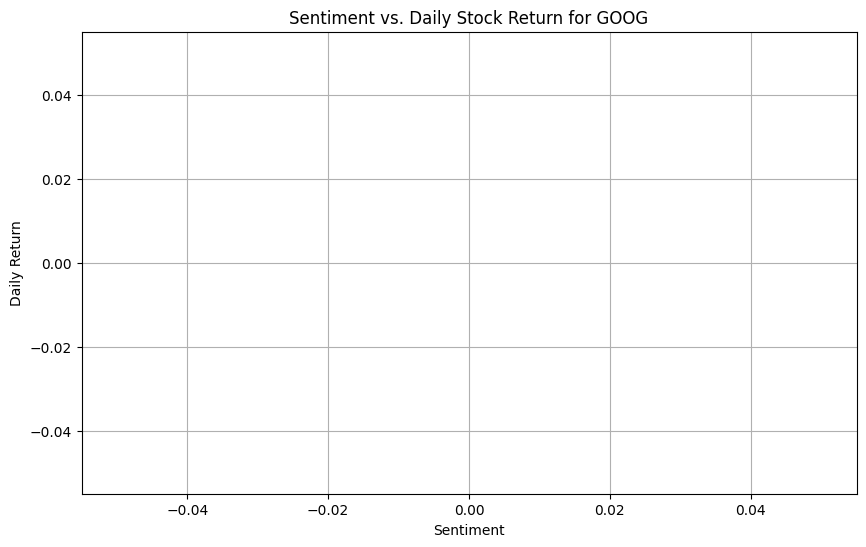

c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


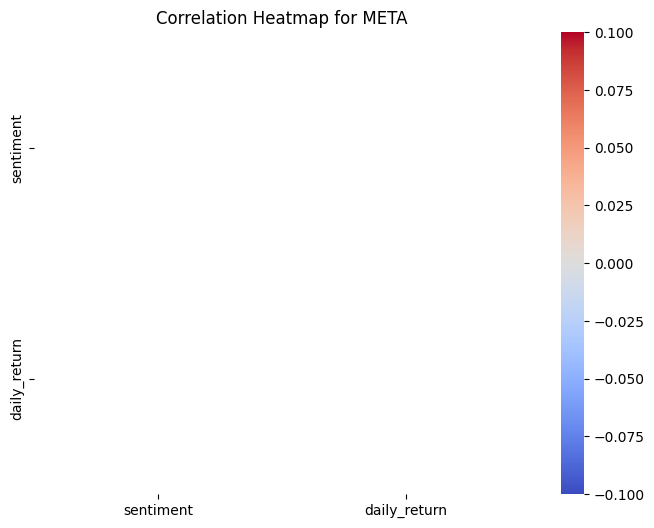

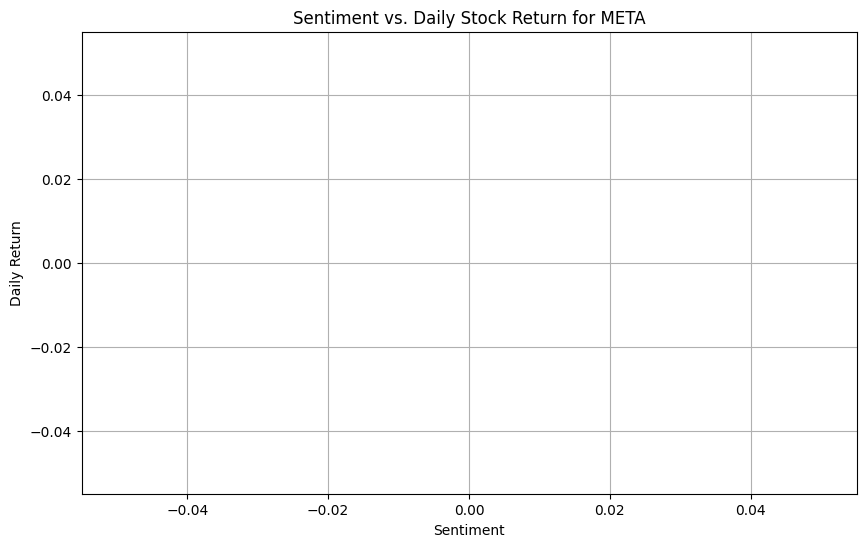

c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


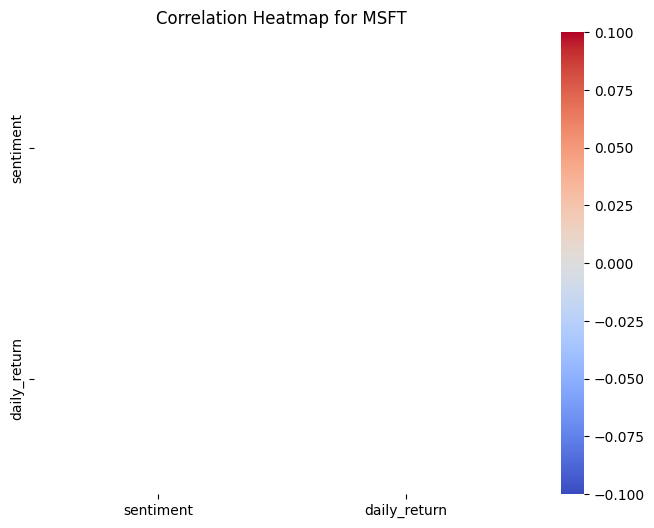

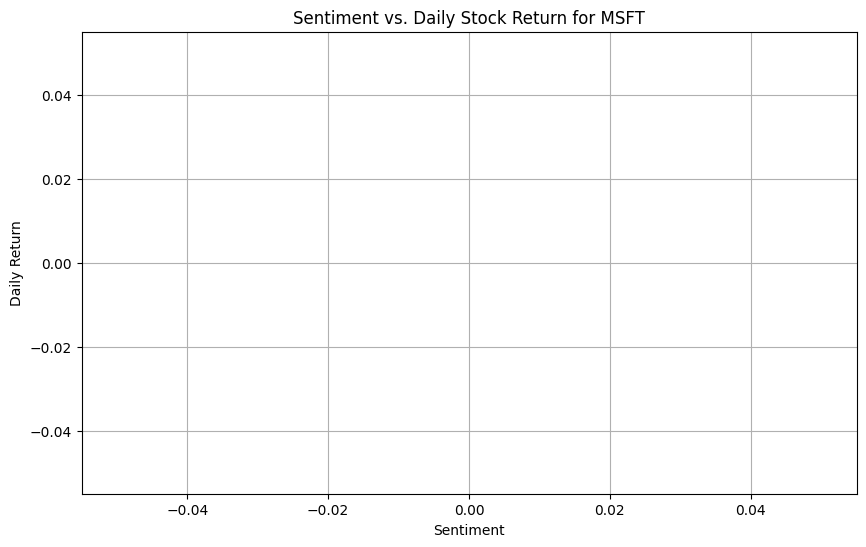

c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


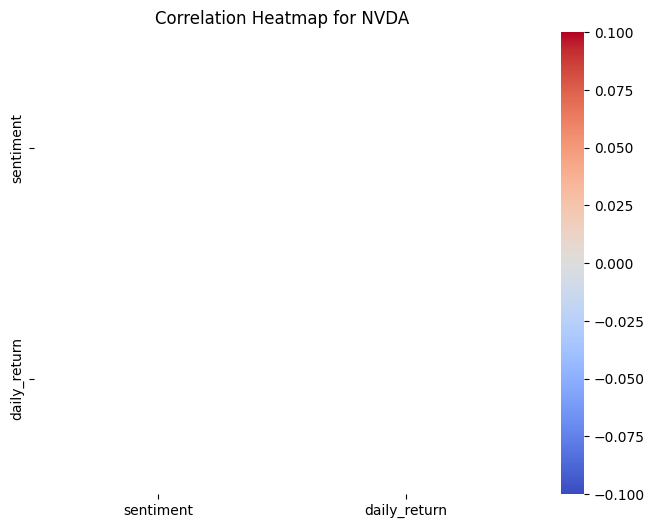

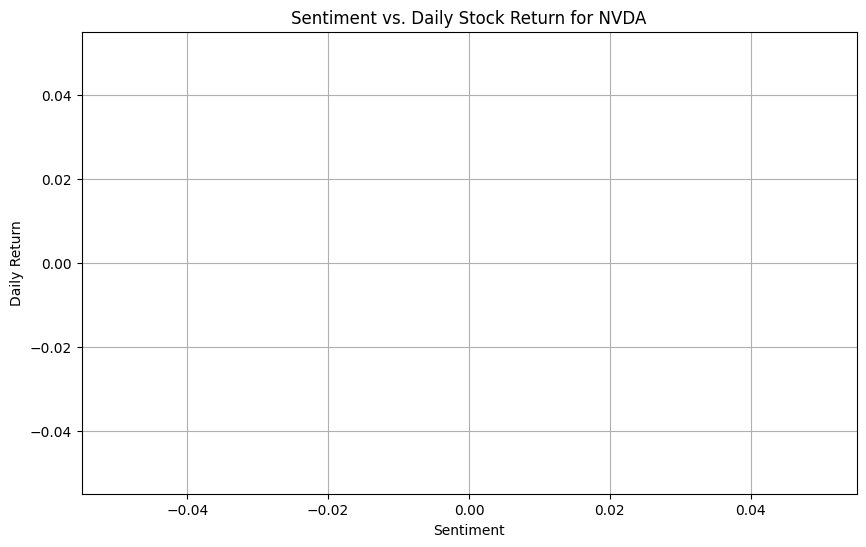

c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


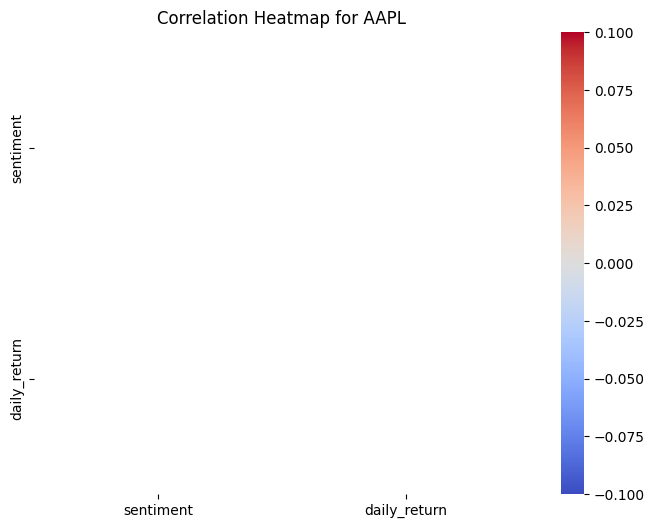

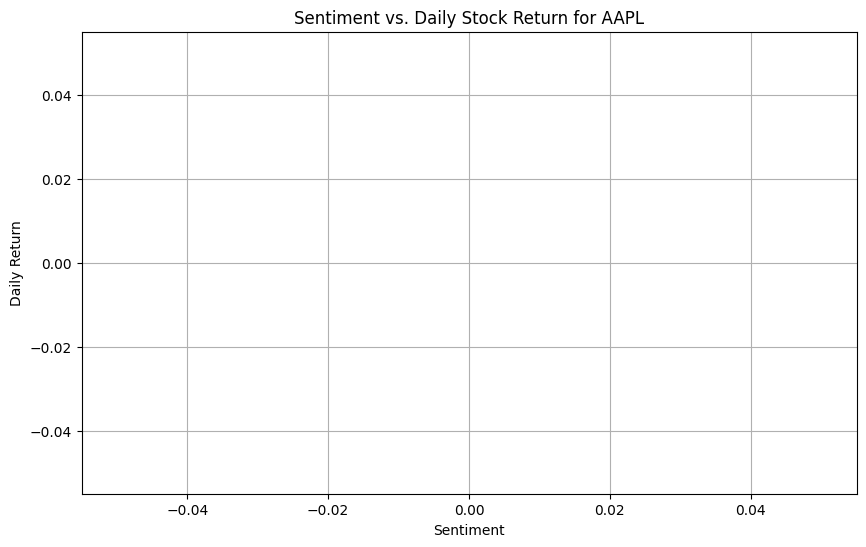

c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


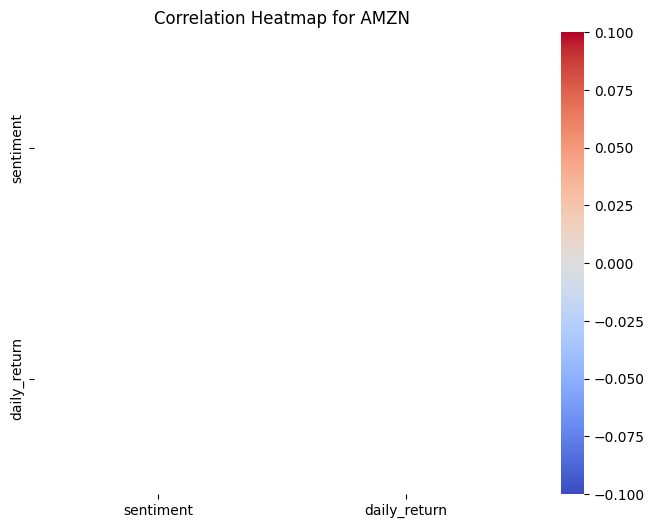

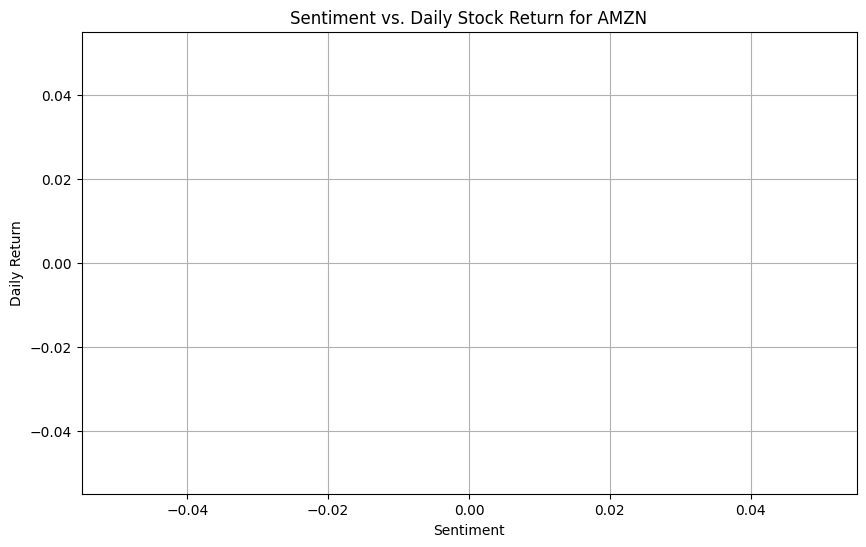

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def process_data(stock_file, news_file):
    # Load the data
    news_data = pd.read_csv(news_file)
    stock_data = pd.read_csv(stock_file)
    
    # Parse dates
    news_data['date'] = pd.to_datetime(news_data['date'], errors='coerce')
    stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce')

    # Remove timezone information to make both timezone-naive
    news_data['date'] = news_data['date'].dt.tz_localize(None)
    stock_data['Date'] = stock_data['Date'].dt.tz_localize(None)


    analyzer = SentimentIntensityAnalyzer()
    news_data['sentiment'] = news_data['headline'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

    # Aggregate sentiment by date
    daily_sentiment = news_data.groupby(news_data['date'])['sentiment'].mean().reset_index()
    # Optionally, fill or drop missing values if necessary
    daily_sentiment = daily_sentiment.dropna()
    stock_data = stock_data.dropna()

    # Calculate daily stock returns
    stock_data['daily_return'] = stock_data['Close'].pct_change()

    # Merge sentiment data with stock data
    # Perform the merge again after ensuring both DataFrames have valid dates
    merged_data = pd.merge(daily_sentiment, stock_data, left_on='date', right_on='Date')

    # Drop rows with missing data in the merged DataFrame
    merged_data = merged_data.dropna(subset=['sentiment', 'daily_return'])
    
    # Strip time information and ensure both columns are of the same type
    daily_sentiment['date'] = daily_sentiment['date'].dt.date
    stock_data['Date'] = stock_data['Date'].dt.date


    # Optionally, fill or drop missing values if necessary
    daily_sentiment = daily_sentiment.dropna()
    stock_data = stock_data.dropna()
    # Perform the merge again after ensuring both DataFrames have valid dates
    merged_data = pd.merge(daily_sentiment, stock_data, left_on='date', right_on='Date')

    # Drop rows with missing data in the merged DataFrame
    merged_data = merged_data.dropna(subset=['sentiment', 'daily_return'])
    
    
    # Calculate correlation
    correlation = merged_data[['sentiment', 'daily_return']].corr().iloc[0, 1]
    
    return correlation, daily_sentiment, stock_data, merged_data

# List of stock datasets and corresponding news datasets
stock_files = {
    'GOOG': '../data/GOOG_historical_data.csv',
    'META': '../data/META_historical_data.csv',
    'MSFT': '../data/MSFT_historical_data.csv',
    'NVDA': '../data/NVDA_historical_data.csv',
    'AAPL': '../data/AAPL_historical_data.csv',
    'AMZN': '../data/AMZN_historical_data.csv',
    # Add paths for other stock datasets
}

news_file = '../data/raw_analyst_ratings.csv'

# Process each dataset and collect results
results = {}
sentiment_data = {}
returns_data = {}
merged_data_dict = {}


for stock, file in stock_files.items():
    correlation, daily_sentiment, stock_data, merged_data = process_data(file, news_file)
    results[stock] = correlation
    sentiment_data[stock] = daily_sentiment
    returns_data[stock] = stock_data
    merged_data_dict[stock] = merged_data

# Print results
for stock, correlation in results.items():
    print(f"Correlation between sentiment and daily return for {stock}: {correlation:.2f}")

# Create a DataFrame for visualization
summary_df = pd.DataFrame(list(results.items()), columns=['Stock', 'Correlation'])
print("\nSummary of Correlations:")
print(summary_df)

# Visualize the correlations with a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Stock', y='Correlation', data=summary_df, palette='viridis')
plt.title('Sentiment vs Daily Return Correlation for Different Stocks')
plt.xlabel('Stock')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot daily sentiment and daily returns
for stock, data in sentiment_data.items():
    plt.figure(figsize=(12, 6))
    plt.plot(data['date'], data['sentiment'], label='Daily Sentiment', color='blue')
    plt.title(f'Daily Sentiment for {stock}')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.legend()
    plt.grid(True)
    plt.show()

for stock, data in returns_data.items():
    plt.figure(figsize=(12, 6))
    plt.plot(data['Date'], data['daily_return'], label='Daily Return', color='red')
    plt.title(f'Daily Returns for {stock}')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create heatmap and scatter plots for merged data
for stock, merged_data in merged_data_dict.items():
    # Correlation Heatmap
    plt.figure(figsize=(8, 6))
    correlation_matrix = merged_data[['sentiment', 'daily_return']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Correlation Heatmap for {stock}')
    plt.show()

    # Scatter plot of sentiment vs daily return
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_data['sentiment'], merged_data['daily_return'], alpha=0.5)
    plt.title(f'Sentiment vs. Daily Stock Return for {stock}')
    plt.xlabel('Sentiment')
    plt.ylabel('Daily Return')
    plt.grid(True)
    plt.show()


c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


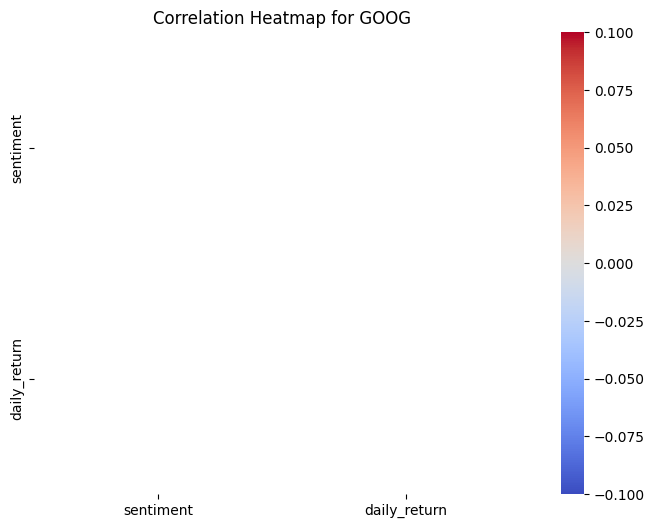

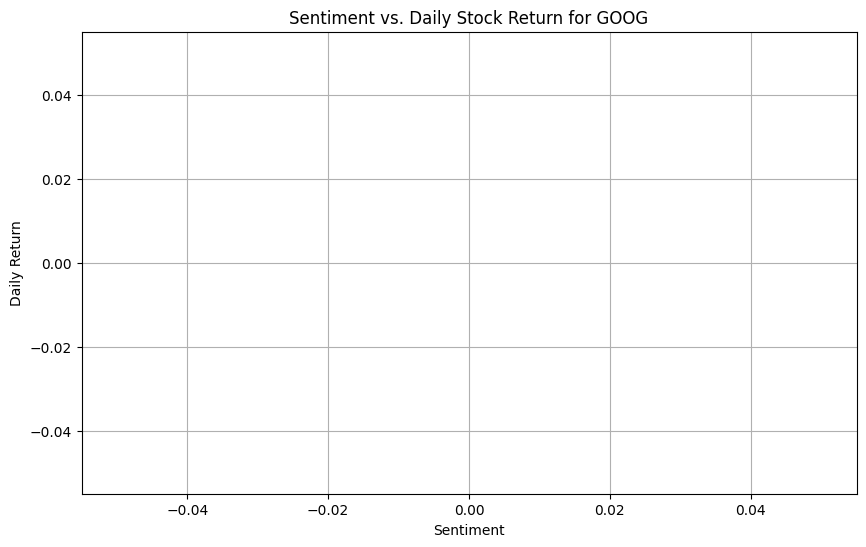

c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


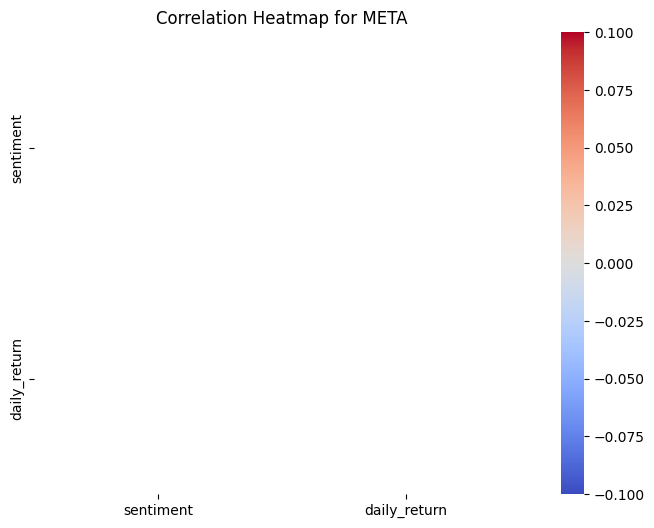

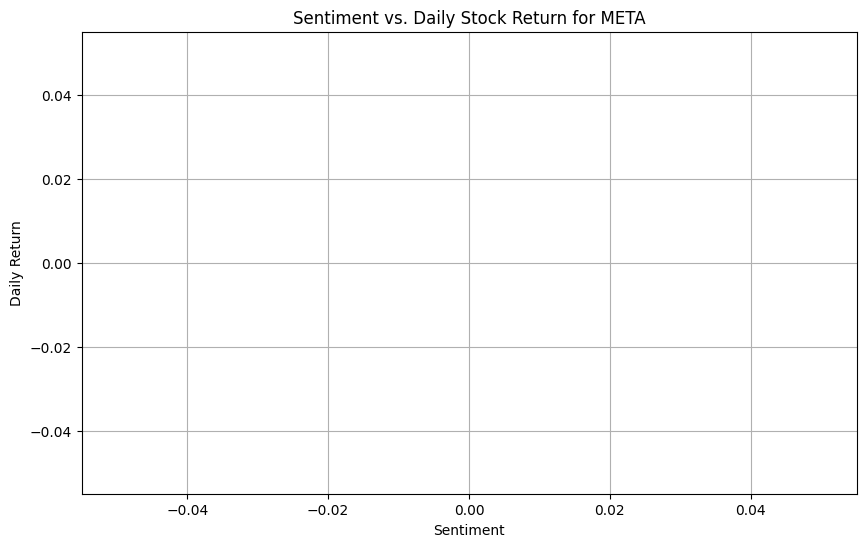

c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


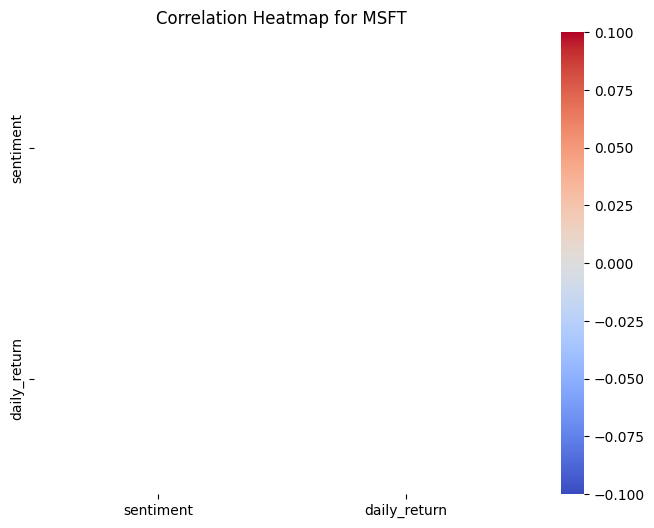

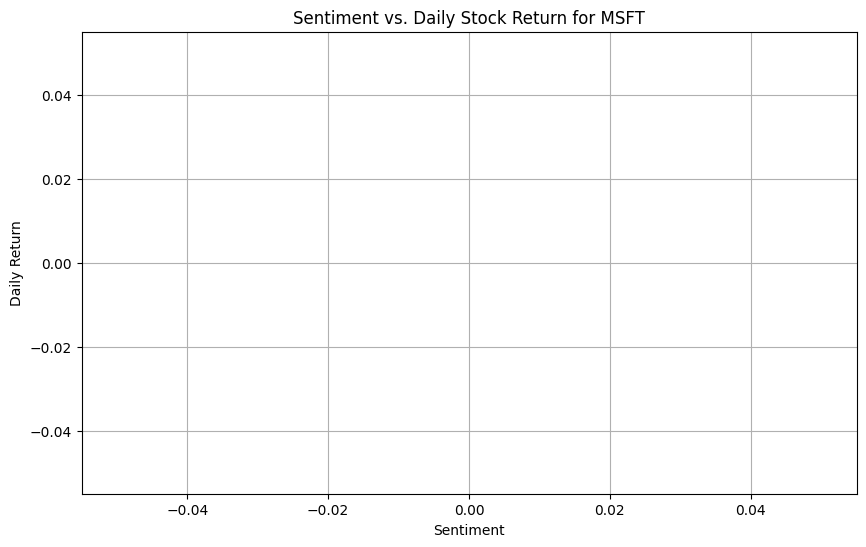

c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


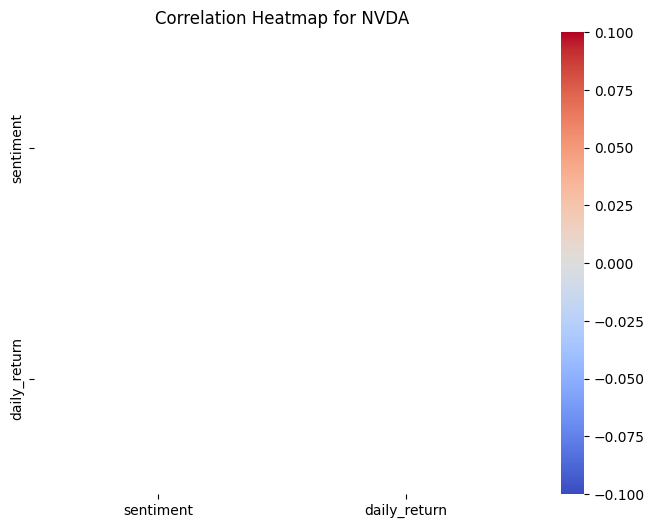

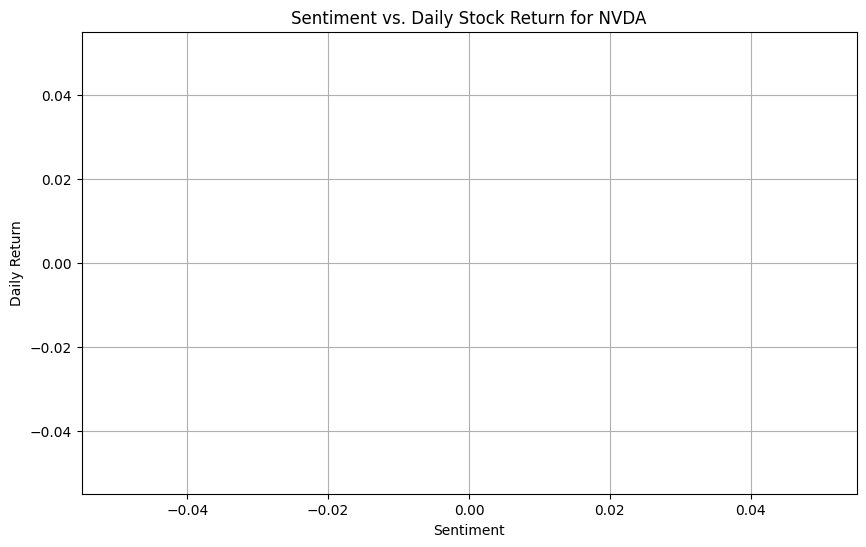

c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


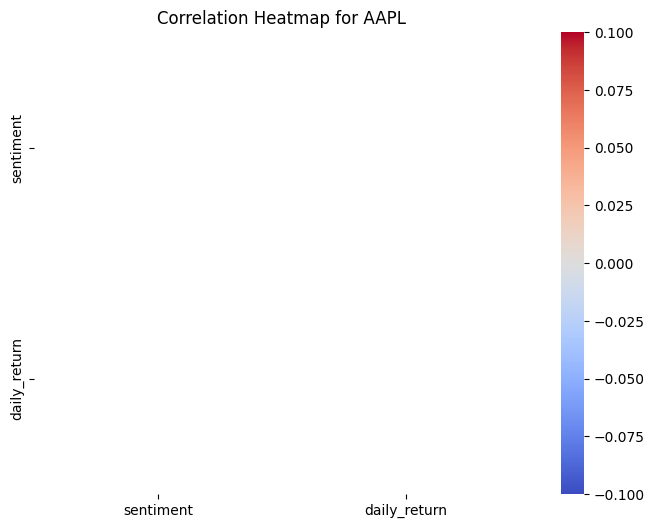

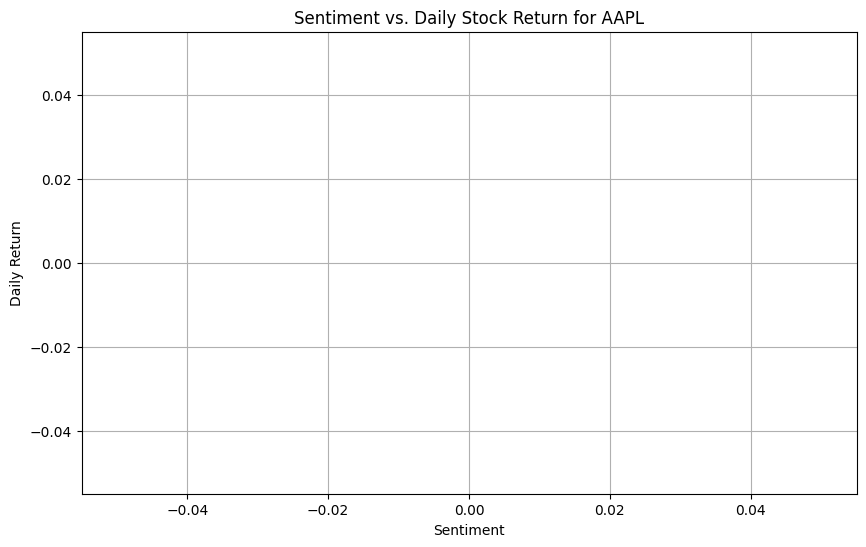

c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


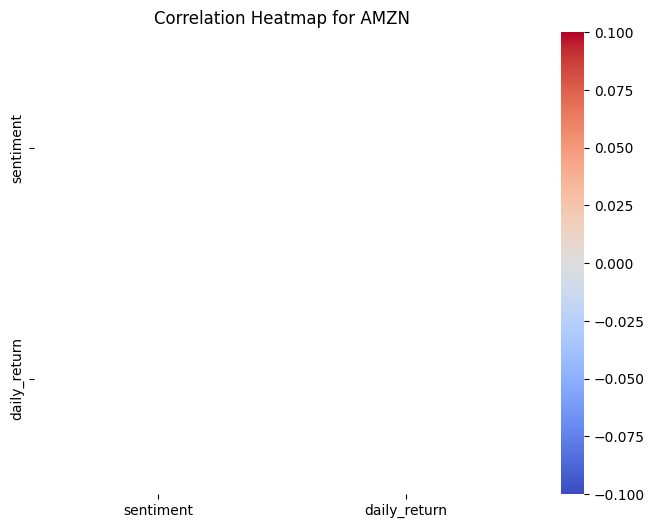

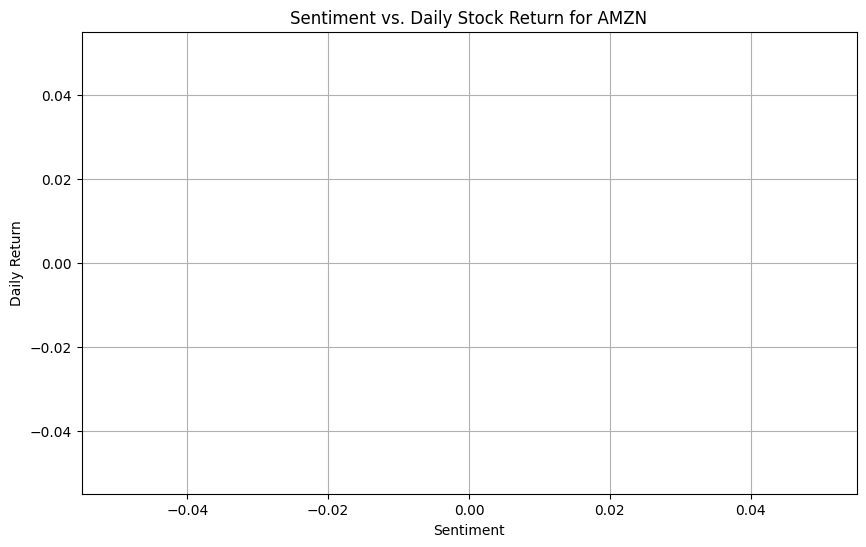

In [29]:
for stock, merged_data in merged_data_dict.items():
    # Correlation Heatmap
    plt.figure(figsize=(8, 6))
    correlation_matrix = merged_data[['sentiment', 'daily_return']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Correlation Heatmap for {stock}')
    plt.show()

    # Scatter plot of sentiment vs daily return
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_data['sentiment'], merged_data['daily_return'], alpha=0.5)
    plt.title(f'Sentiment vs. Daily Stock Return for {stock}')
    plt.xlabel('Sentiment')
    plt.ylabel('Daily Return')
    plt.grid(True)
    plt.show()

Daily aggregate of Sentiment Data:
                 date  sentiment
0 2011-04-27 21:01:48     0.0000
1 2011-04-28 13:49:29     0.0000
2 2011-04-28 15:00:36     0.2500
3 2011-04-29 13:47:06     0.0000
4 2011-04-29 16:11:05     0.7351
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36011 entries, 0 to 36010
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       36011 non-null  datetime64[ns]
 1   sentiment  36011 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 562.8 KB
None
Daily aggregate of Sentiment Data:
                 date  sentiment
0 2011-04-27 21:01:48     0.0000
1 2011-04-28 13:49:29     0.0000
2 2011-04-28 15:00:36     0.2500
3 2011-04-29 13:47:06     0.0000
4 2011-04-29 16:11:05     0.7351
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36011 entries, 0 to 36010
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     -

C:\Users\Akram 1\AppData\Local\Temp\ipykernel_10312\2349162114.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Stock', y='Correlation', data=summary_df, palette='viridis')


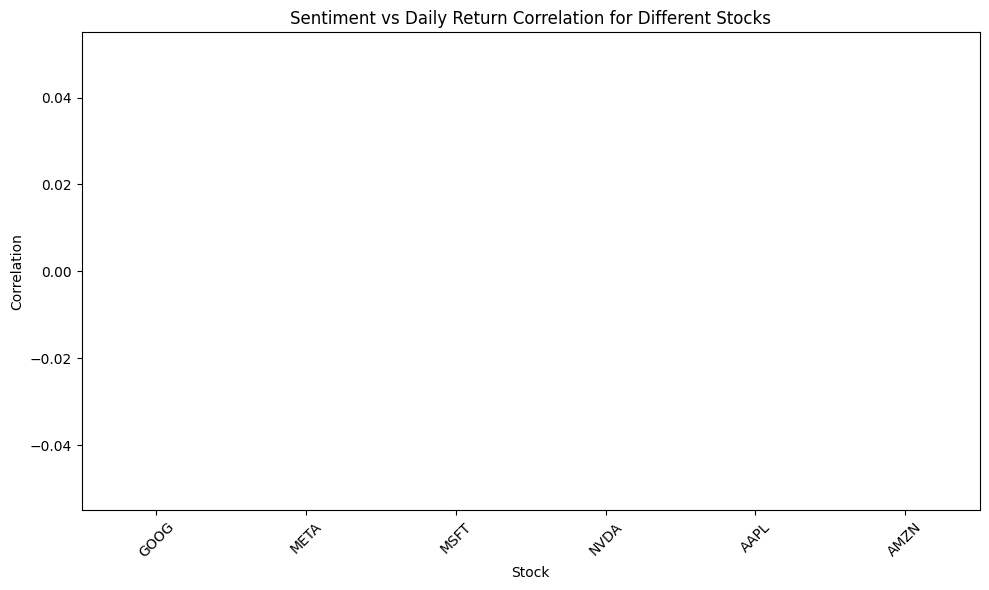

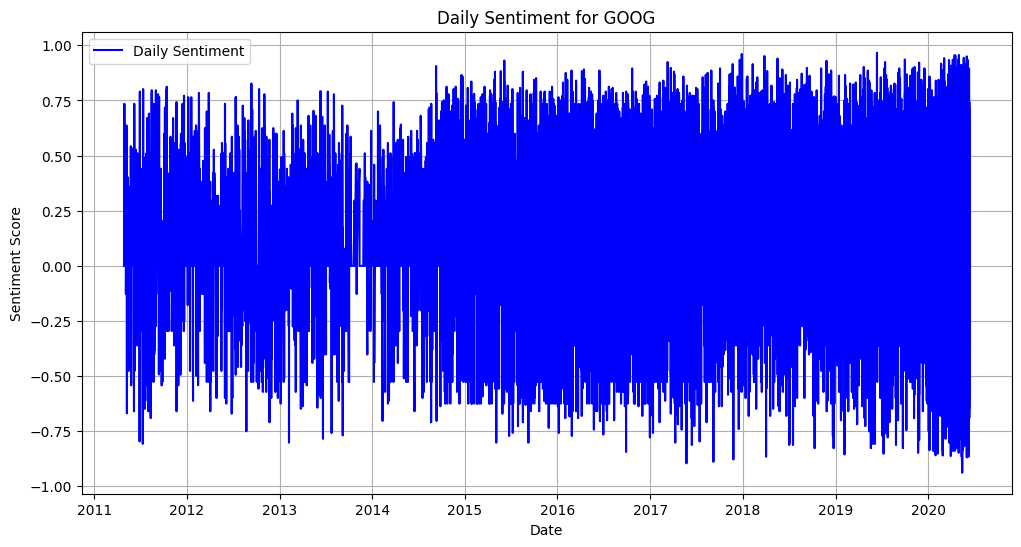

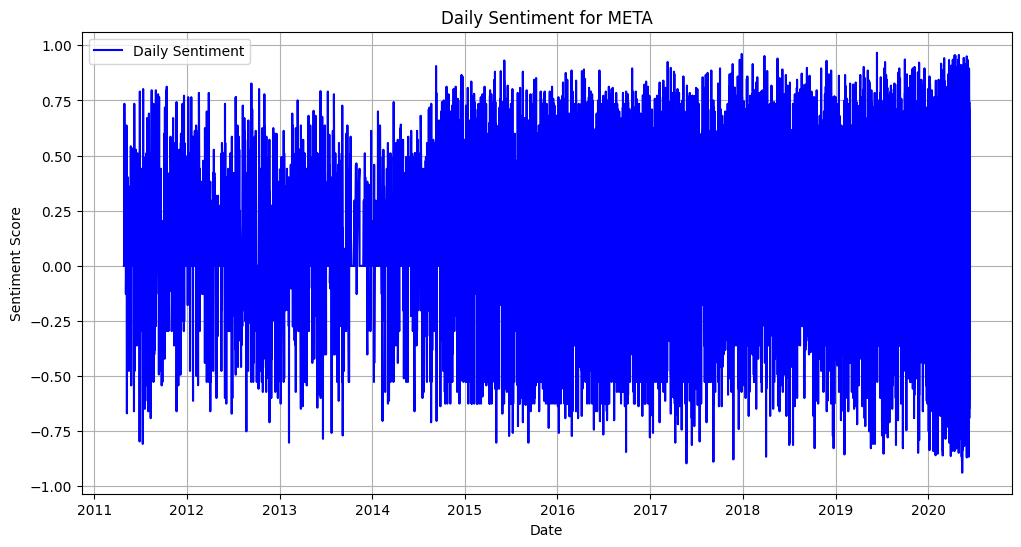

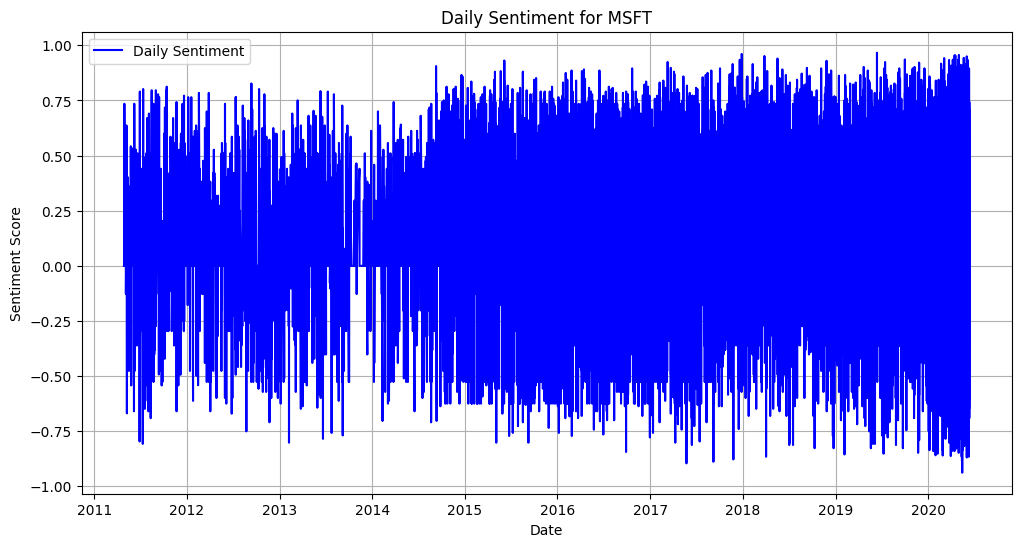

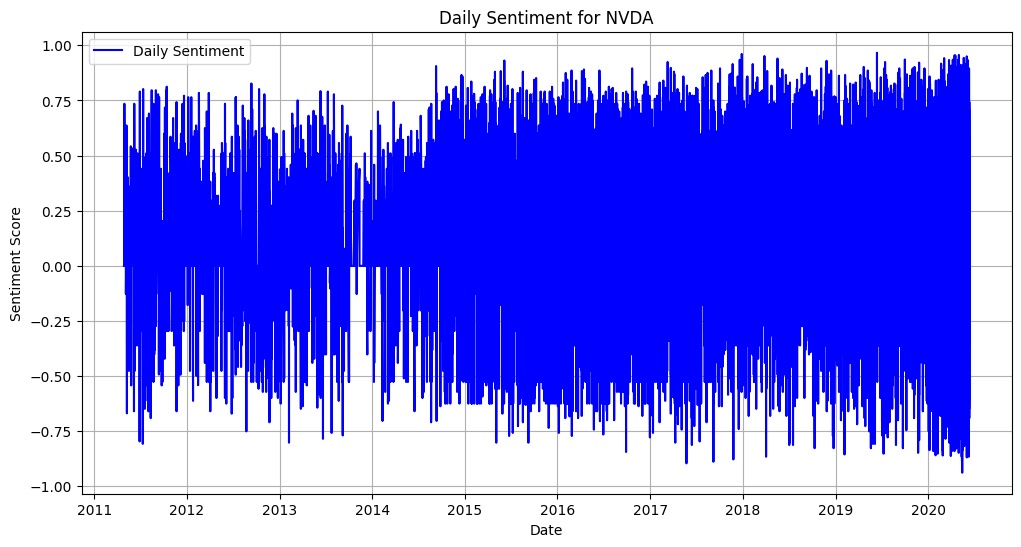

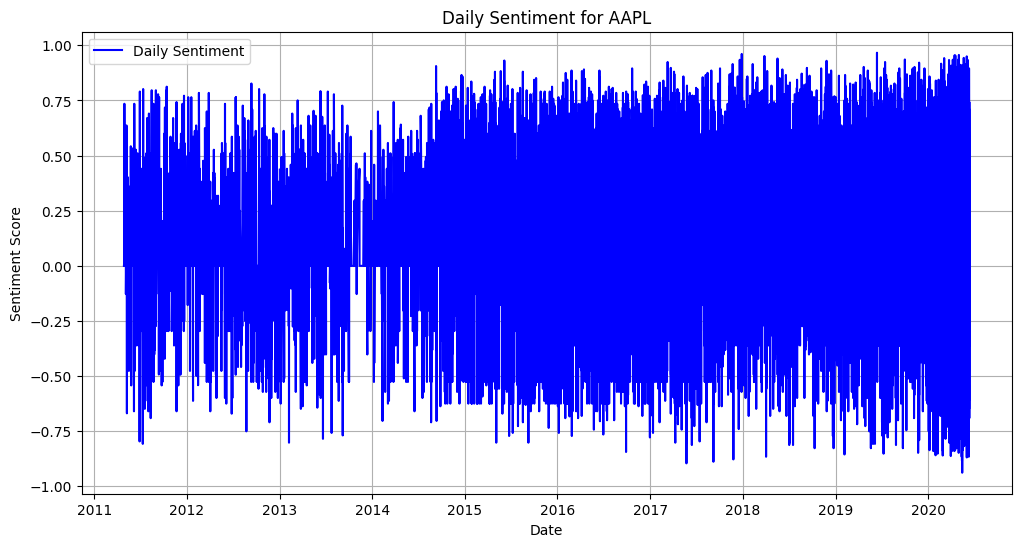

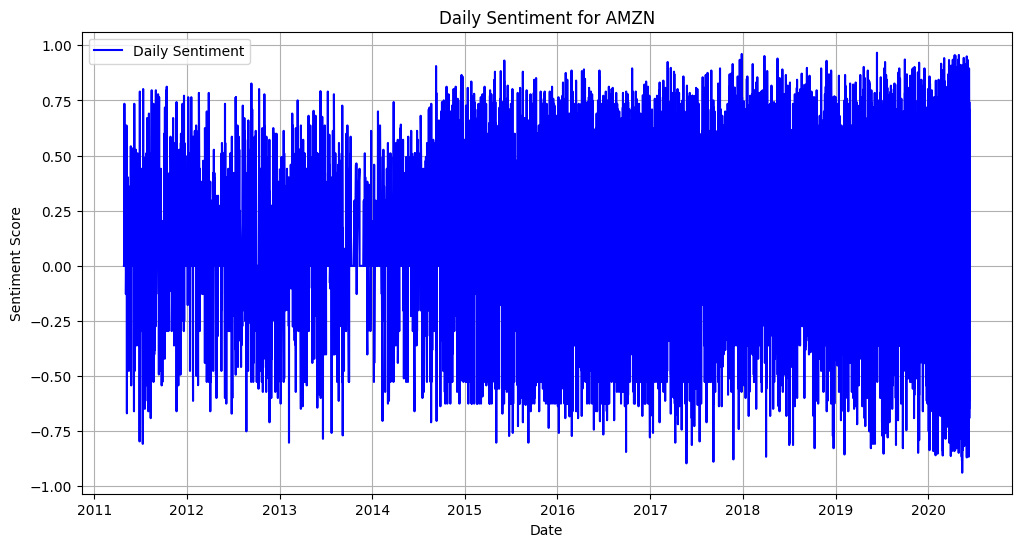

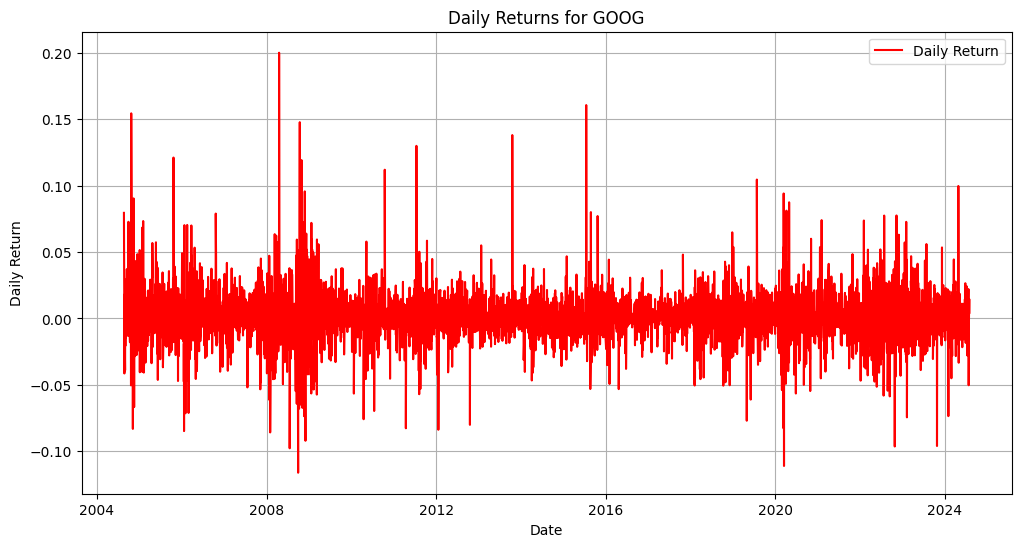

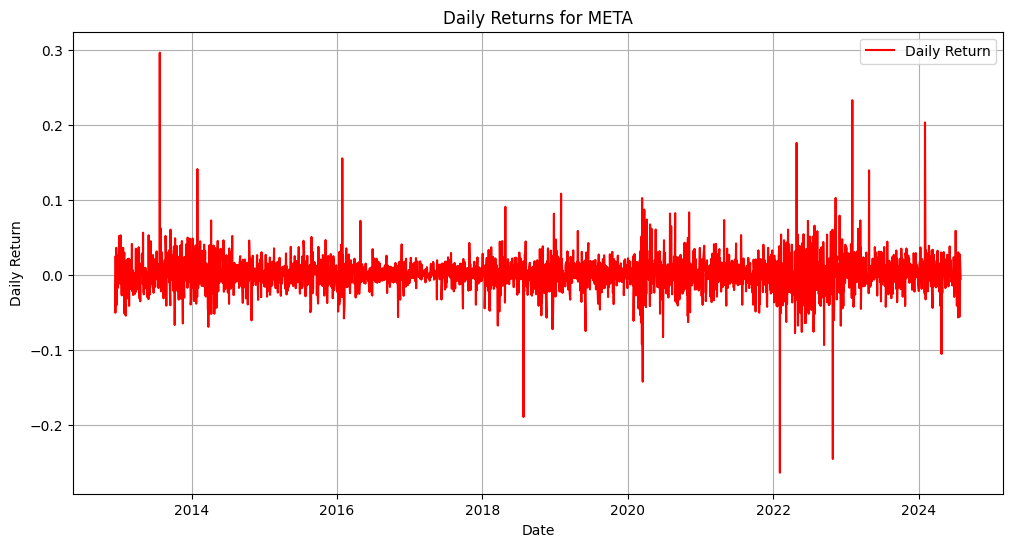

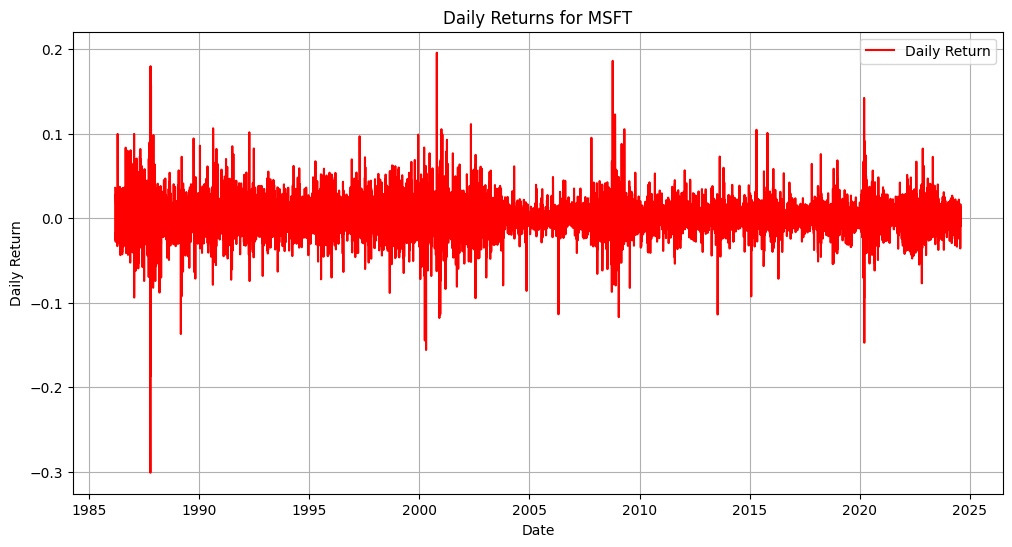

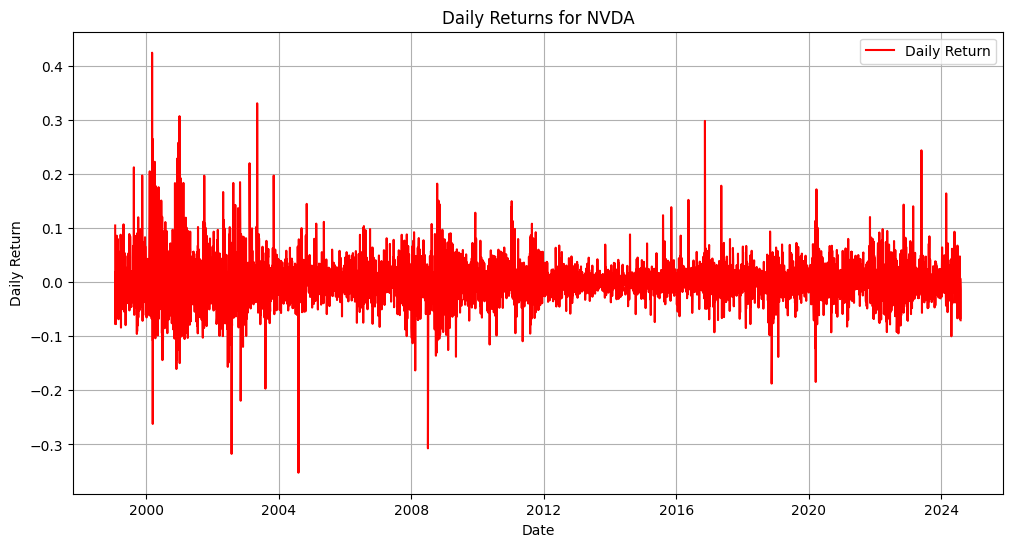

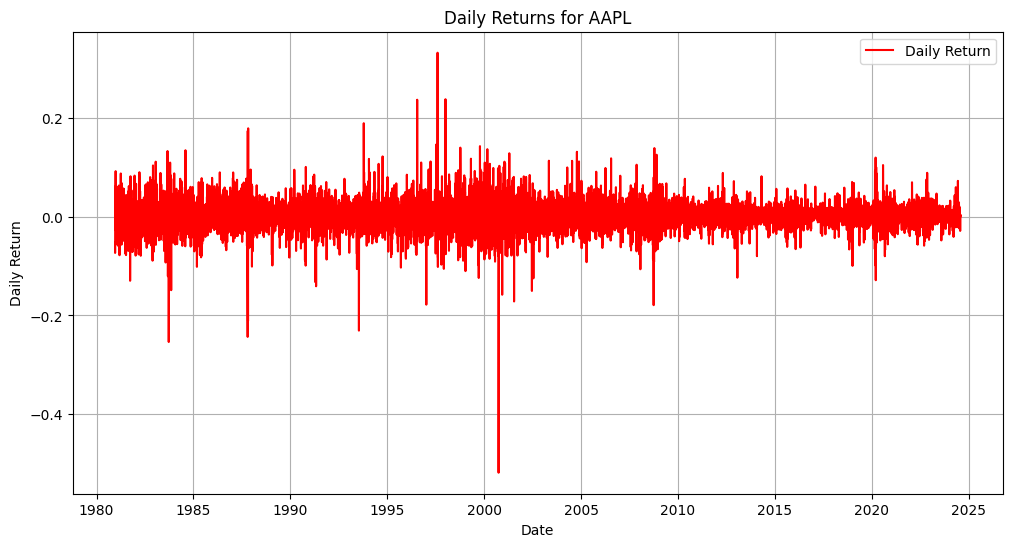

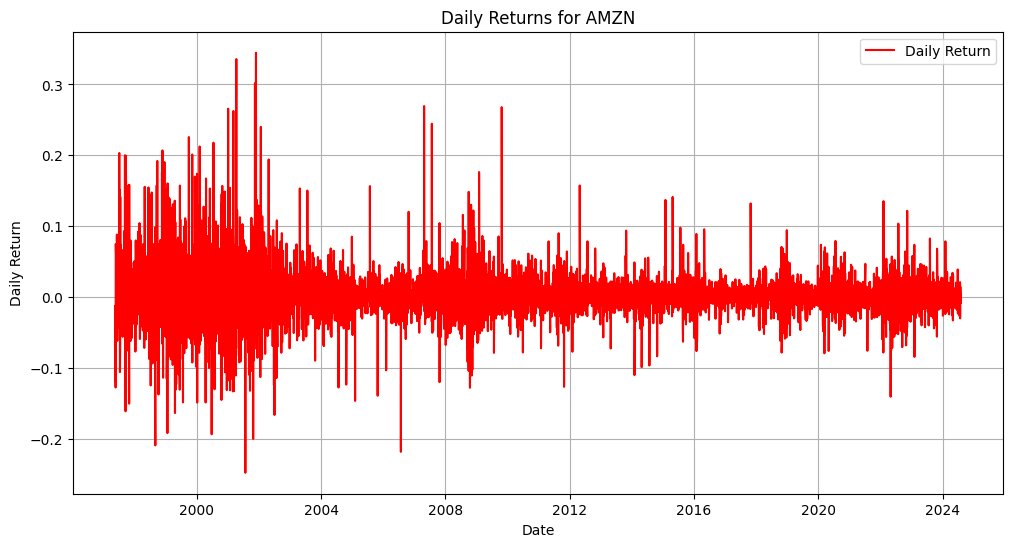

c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


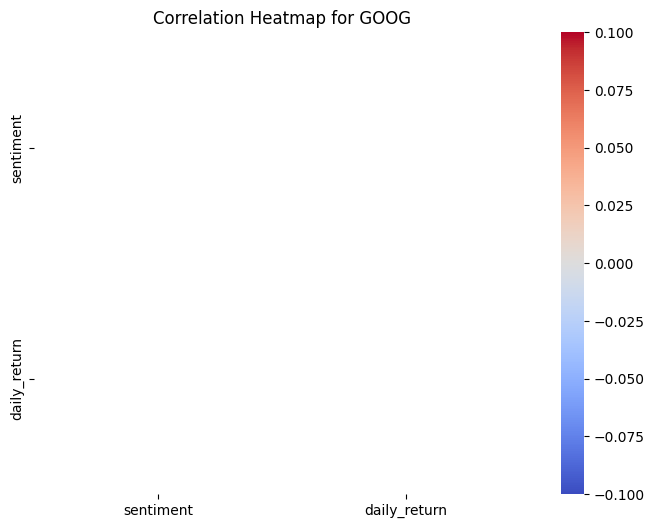

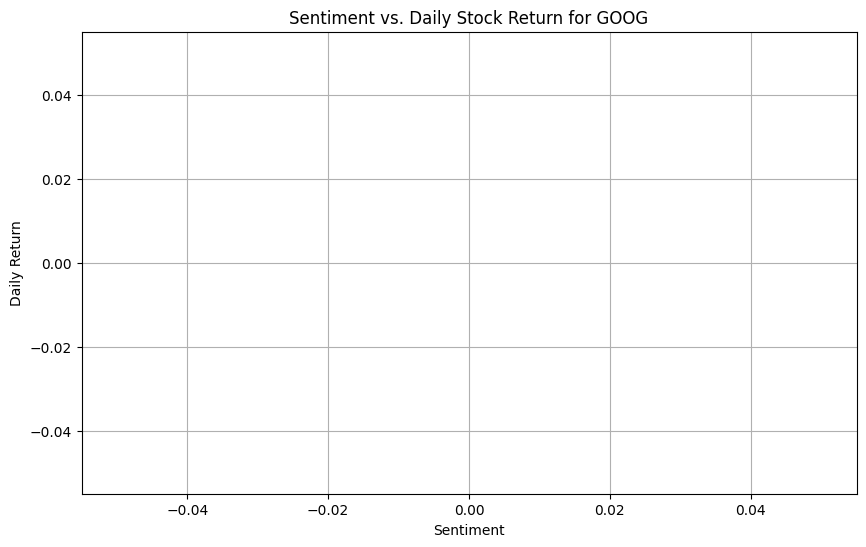

c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


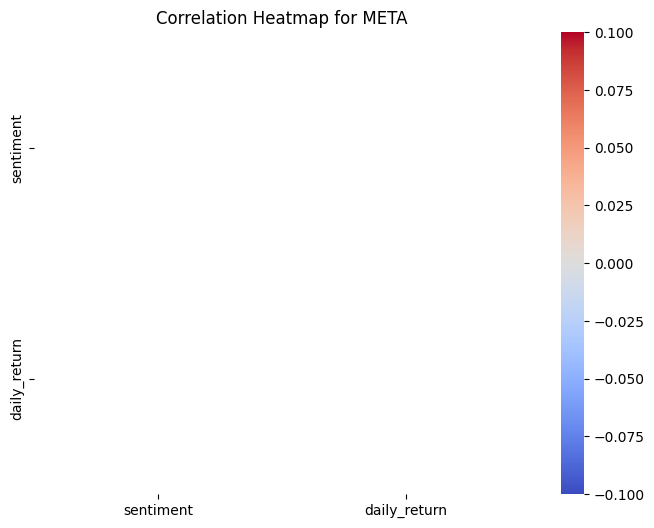

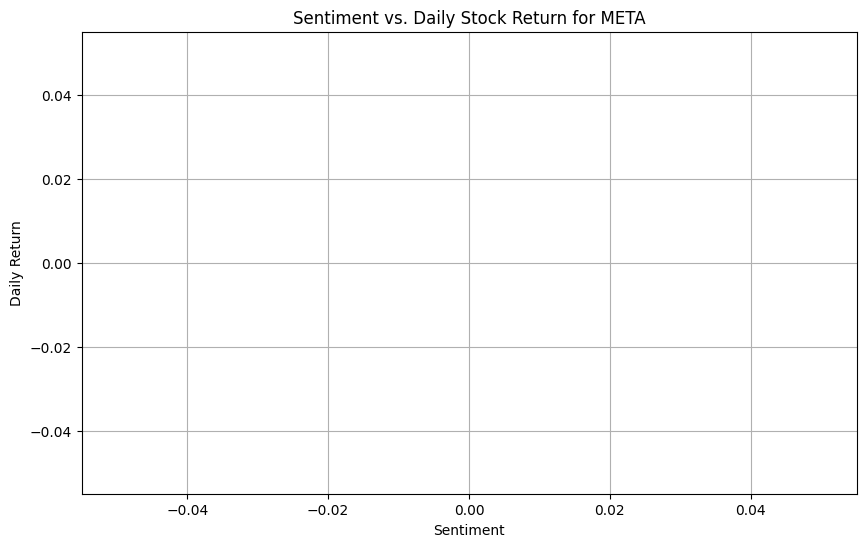

c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


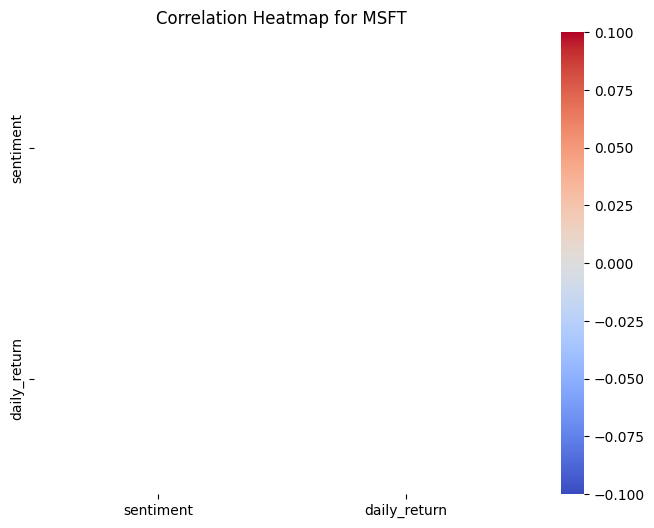

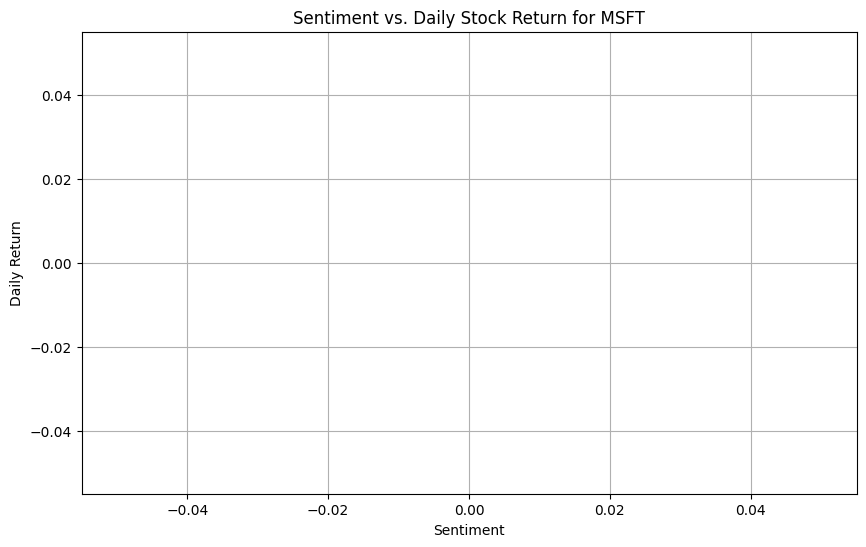

c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


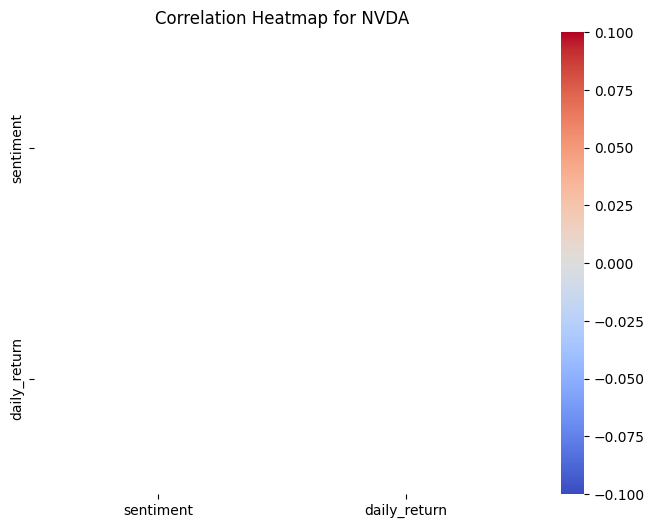

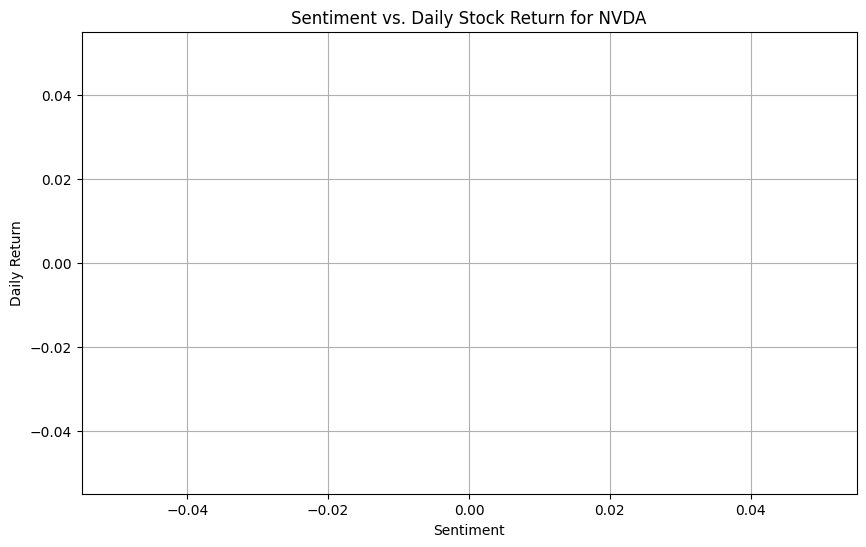

c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


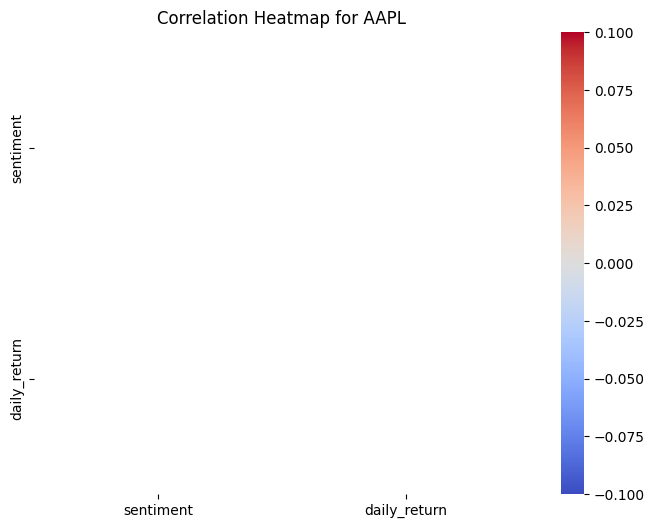

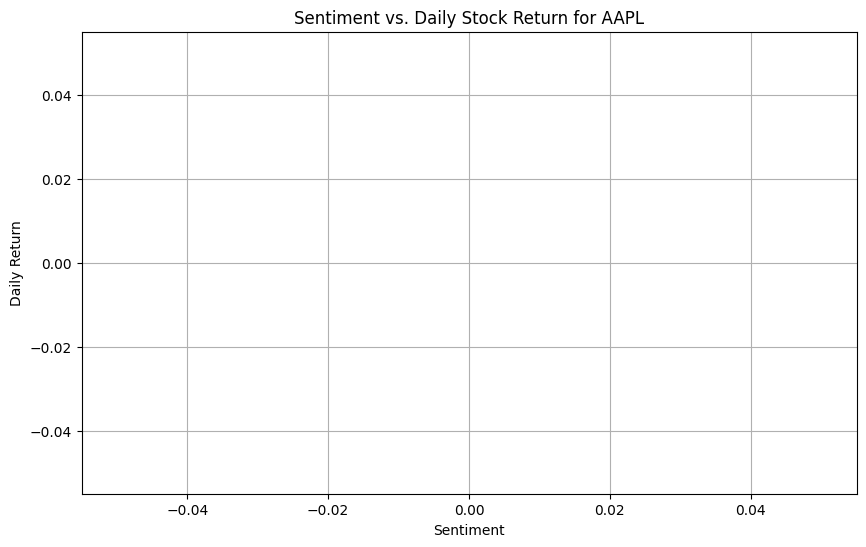

c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\kifiya-week1\Kifiya-Ai-week1\myvenv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


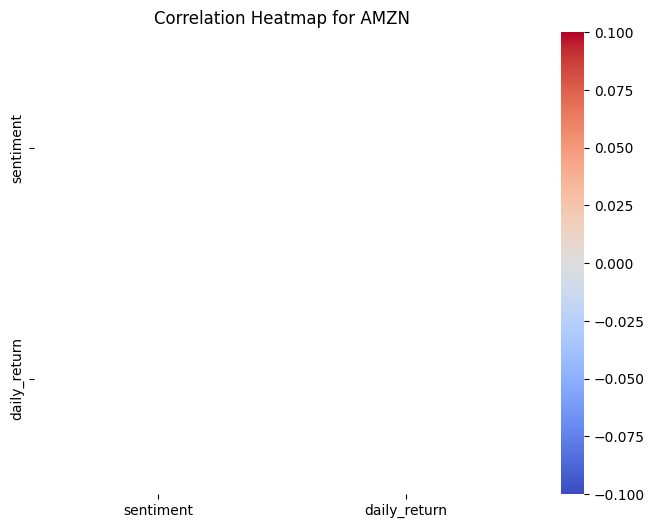

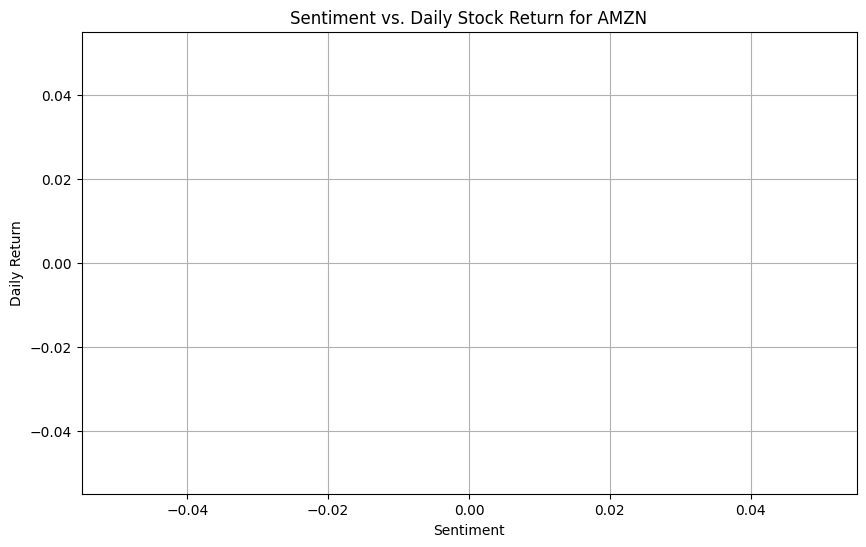

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def process_data(stock_file, news_file):
    # Load the data
    news_data = pd.read_csv(news_file)
    stock_data = pd.read_csv(stock_file)
    
    # Parse dates
    news_data['date'] = pd.to_datetime(news_data['date'], errors='coerce')
    stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce')

    # Remove timezone information to make both timezone-naive
    news_data['date'] = news_data['date'].dt.tz_localize(None)
    stock_data['Date'] = stock_data['Date'].dt.tz_localize(None)

    # Sentiment analysis on news data
    analyzer = SentimentIntensityAnalyzer()
    news_data['sentiment'] = news_data['headline'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

    # Aggregate sentiment by date
    daily_sentiment = news_data.groupby(news_data['date'])['sentiment'].mean().reset_index()
    daily_sentiment = daily_sentiment.dropna()

    # Calculate daily stock returns
    stock_data['daily_return'] = stock_data['Close'].pct_change()
    stock_data = stock_data.dropna()

    # Merge sentiment data with stock data
     # Optionally, fill or drop missing values if necessary
    daily_sentiment = daily_sentiment.dropna()
    stock_data = stock_data.dropna()
    # Perform the merge again after ensuring both DataFrames have valid dates
    merged_data = pd.merge(daily_sentiment, stock_data, left_on='date', right_on='Date')

    #merged_data = pd.merge(daily_sentiment, stock_data, left_on='date', right_on='Date')
   # merged_data = merged_data.dropna(subset=['sentiment', 'daily_return'])

    # Print daily sentiment for inspection
    print("Daily aggregate of Sentiment Data:")
    print(daily_sentiment.head())
    print(daily_sentiment.info())

    # Calculate correlation between sentiment and daily return
    correlation = merged_data[['sentiment', 'daily_return']].corr().iloc[0, 1]
    
    return correlation, daily_sentiment, stock_data, merged_data

# List of stock datasets and corresponding news datasets
stock_files = {
    'GOOG': '../data/GOOG_historical_data.csv',
    'META': '../data/META_historical_data.csv',
    'MSFT': '../data/MSFT_historical_data.csv',
    'NVDA': '../data/NVDA_historical_data.csv',
    'AAPL': '../data/AAPL_historical_data.csv',
    'AMZN': '../data/AMZN_historical_data.csv',
}

news_file = '../data/raw_analyst_ratings.csv'

# Initialize dictionaries to store results
results = {}
sentiment_data = {}
returns_data = {}
merged_data_dict = {}

# Process each dataset and collect results
for stock, file in stock_files.items():
    correlation, daily_sentiment, stock_data, merged_data = process_data(file, news_file)
    results[stock] = correlation
    sentiment_data[stock] = daily_sentiment
    returns_data[stock] = stock_data
    merged_data_dict[stock] = merged_data

# Print correlation results
for stock, correlation in results.items():
    print(f"Correlation between sentiment and daily return for {stock}: {correlation:.2f}")

# Create a DataFrame for visualization
summary_df = pd.DataFrame(list(results.items()), columns=['Stock', 'Correlation'])
print("\nSummary of Correlations:")
print(summary_df)

# Visualize correlations with a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Stock', y='Correlation', data=summary_df, palette='viridis')
plt.title('Sentiment vs Daily Return Correlation for Different Stocks')
plt.xlabel('Stock')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot daily sentiment and daily returns
for stock, data in sentiment_data.items():
    plt.figure(figsize=(12, 6))
    plt.plot(data['date'], data['sentiment'], label='Daily Sentiment', color='blue')
    plt.title(f'Daily Sentiment for {stock}')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.legend()
    plt.grid(True)
    plt.show()

for stock, data in returns_data.items():
    plt.figure(figsize=(12, 6))
    plt.plot(data['Date'], data['daily_return'], label='Daily Return', color='red')
    plt.title(f'Daily Returns for {stock}')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create heatmap and scatter plots for merged data
for stock, merged_data in merged_data_dict.items():
    # Correlation Heatmap
    plt.figure(figsize=(8, 6))
    correlation_matrix = merged_data[['sentiment', 'daily_return']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Correlation Heatmap for {stock}')
    plt.show()

    # Scatter plot of sentiment vs daily return
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_data['sentiment'], merged_data['daily_return'], alpha=0.5)
    plt.title(f'Sentiment vs. Daily Stock Return for {stock}')
    plt.xlabel('Sentiment')
    plt.ylabel('Daily Return')
    plt.grid(True)
    plt.show()
